In [2]:
# import laybrarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pathlib import Path
from warnings import simplefilter
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

simplefilter("ignore")


In [3]:
simplefilter("ignore")

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig



In [4]:
# read the orginal data from the csv file
df1 = pd.read_csv("well2.csv")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce') #convert date column to datetime format
# =========================================
# create a dummy date time with freq = 1D to see which days we have no data
df = pd.DataFrame({
    'date': pd.date_range(start='2013-07-24', periods=1152, freq='D')
})
# =========================================
# Merge on the 'date' column, using 'left' join to keep all dates from df1
df = df.merge(df1, on='date', how='left')
df.head()

date  well_name        bhp       bht  dp_tubing  AVG_CHOKE_SIZE_P  \
0 2013-07-24  15/9-F-11    1.92627   0.35220   26.12304          3.256548   
1 2013-07-25  15/9-F-11  163.59426  60.31574   61.47308          8.549131   
2 2013-07-26        NaN        NaN       NaN        NaN               NaN   
3 2013-07-27        NaN        NaN       NaN        NaN               NaN   
4 2013-07-28  15/9-F-11    0.00000   0.00000    0.00000          2.464222   

         thp       tht  choke_size_percentage           QL             QG  \
0   28.04931  18.19463               18.85147    61.200000    9505.611429   
1  102.12118  36.96744               72.95519   725.000000  108940.110000   
2        NaN       NaN                    NaN          NaN            NaN   
3        NaN       NaN                    NaN          NaN            NaN   
4    0.00000   0.00000                0.00000  1600.285714  257479.142857   

   well6_inj  well7_inj  
0     2476.0     3070.0  
1     4706.0     4007.0  
2        NaN        NaN  
3        NaN        NaN  
4       87.0      146.0

In [5]:
df.describe()

date          bhp          bht    dp_tubing  \
count                 1152  1119.000000  1119.000000  1119.000000   
mean   2015-02-19 12:00:00   235.070652   105.562503   183.138002   
min    2013-07-24 00:00:00     0.000000     0.000000     0.000000   
25%    2014-05-07 18:00:00   220.131695   105.653994   167.802310   
50%    2015-02-19 12:00:00   230.572963   105.940026   174.778824   
75%    2015-12-04 06:00:00   250.813843   106.323882   196.625029   
max    2016-09-17 00:00:00   296.354607   106.699530   248.705198   
std                    NaN    22.429092     5.660106    22.707755   

       AVG_CHOKE_SIZE_P          thp          tht  choke_size_percentage  \
count       1119.000000  1119.000000  1119.000000            1119.000000   
mean          37.596787    51.979339    70.073802              24.355322   
min            1.443510     0.000000     0.000000               0.000000   
25%           11.238920    31.251107    63.371771               4.647525   
50%           15.059147    51.096747    69.742230              21.776210   
75%           97.916667    69.103641    78.777729              40.476889   
max          100.000000   102.219531    85.028862              72.955190   
std           38.075331    20.118944    10.996093              18.985923   

                QL             QG    well6_inj    well7_inj  
count  1119.000000    1119.000000  1119.000000  1119.000000  
mean   2040.878068  159927.183650   365.053170   413.024002  
min      61.200000    9505.611429     0.000000     0.000000  
25%    1336.025000  135086.395000     0.000000     0.000000  
50%    1598.199606  166589.510000     0.000000     0.000000  
75%    2843.290000  188823.910000     0.000000     0.000000  
max    4618.775565  344150.263368  6122.657798  7101.000000  
std     879.906632   53677.532907  1327.710334  1511.865351

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1152 non-null   datetime64[ns]
 1   well_name              1119 non-null   object        
 2   bhp                    1119 non-null   float64       
 3   bht                    1119 non-null   float64       
 4   dp_tubing              1119 non-null   float64       
 5   AVG_CHOKE_SIZE_P       1119 non-null   float64       
 6   thp                    1119 non-null   float64       
 7   tht                    1119 non-null   float64       
 8   choke_size_percentage  1119 non-null   float64       
 9   QL                     1119 non-null   float64       
 10  QG                     1119 non-null   float64       
 11  well6_inj              1119 non-null   float64       
 12  well7_inj              1119 non-null   float64       
dtypes: 

In [7]:
df.isna().sum()

date                      0
well_name                33
bhp                      33
bht                      33
dp_tubing                33
AVG_CHOKE_SIZE_P         33
thp                      33
tht                      33
choke_size_percentage    33
QL                       33
QG                       33
well6_inj                33
well7_inj                33
dtype: int64

In [8]:
df = df.loc[:, [
    "date", "bhp", "bht",
    "dp_tubing", "AVG_CHOKE_SIZE_P",
    "QG"
]]

df.head()

date        bhp       bht  dp_tubing  AVG_CHOKE_SIZE_P             QG
0 2013-07-24    1.92627   0.35220   26.12304          3.256548    9505.611429
1 2013-07-25  163.59426  60.31574   61.47308          8.549131  108940.110000
2 2013-07-26        NaN       NaN        NaN               NaN            NaN
3 2013-07-27        NaN       NaN        NaN               NaN            NaN
4 2013-07-28    0.00000   0.00000    0.00000          2.464222  257479.142857

In [9]:
df.set_index('date', inplace=True)
df['Time'] = np.arange(len(df.index))

In [10]:
df["log_bht"] = np.log10(df["bht"])
# df["felter_bht"] = df["bht"][df["bht"]> 80]

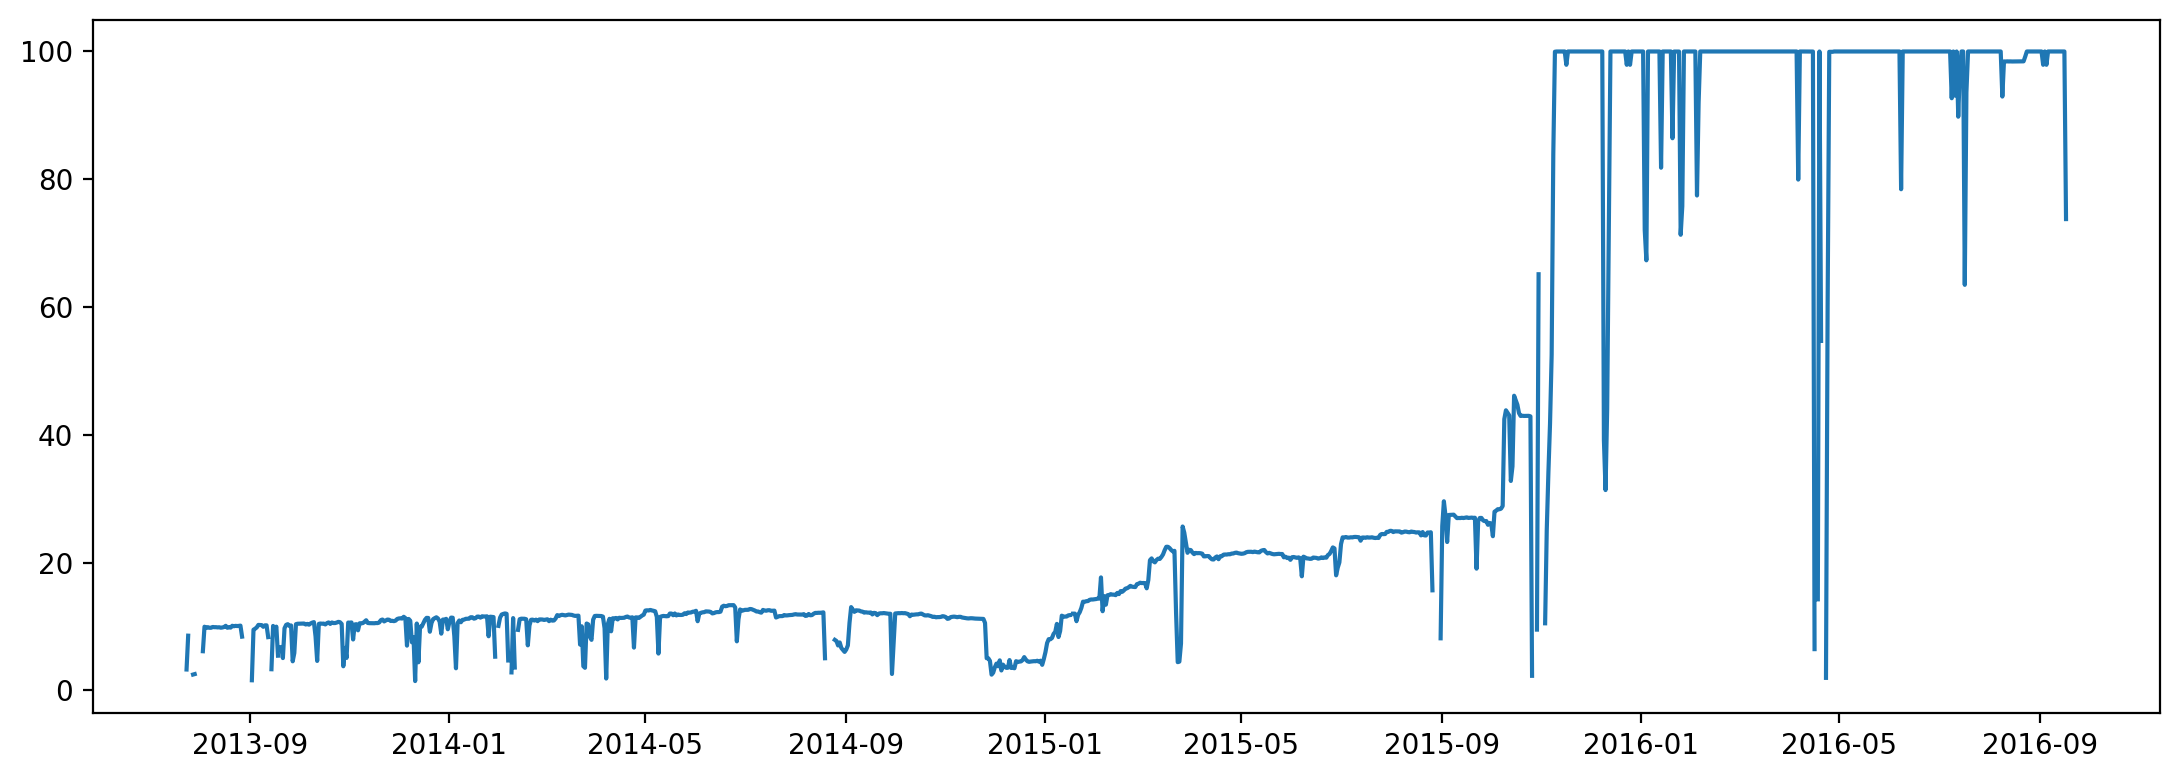

In [11]:
plt.plot(df.index, df.AVG_CHOKE_SIZE_P)

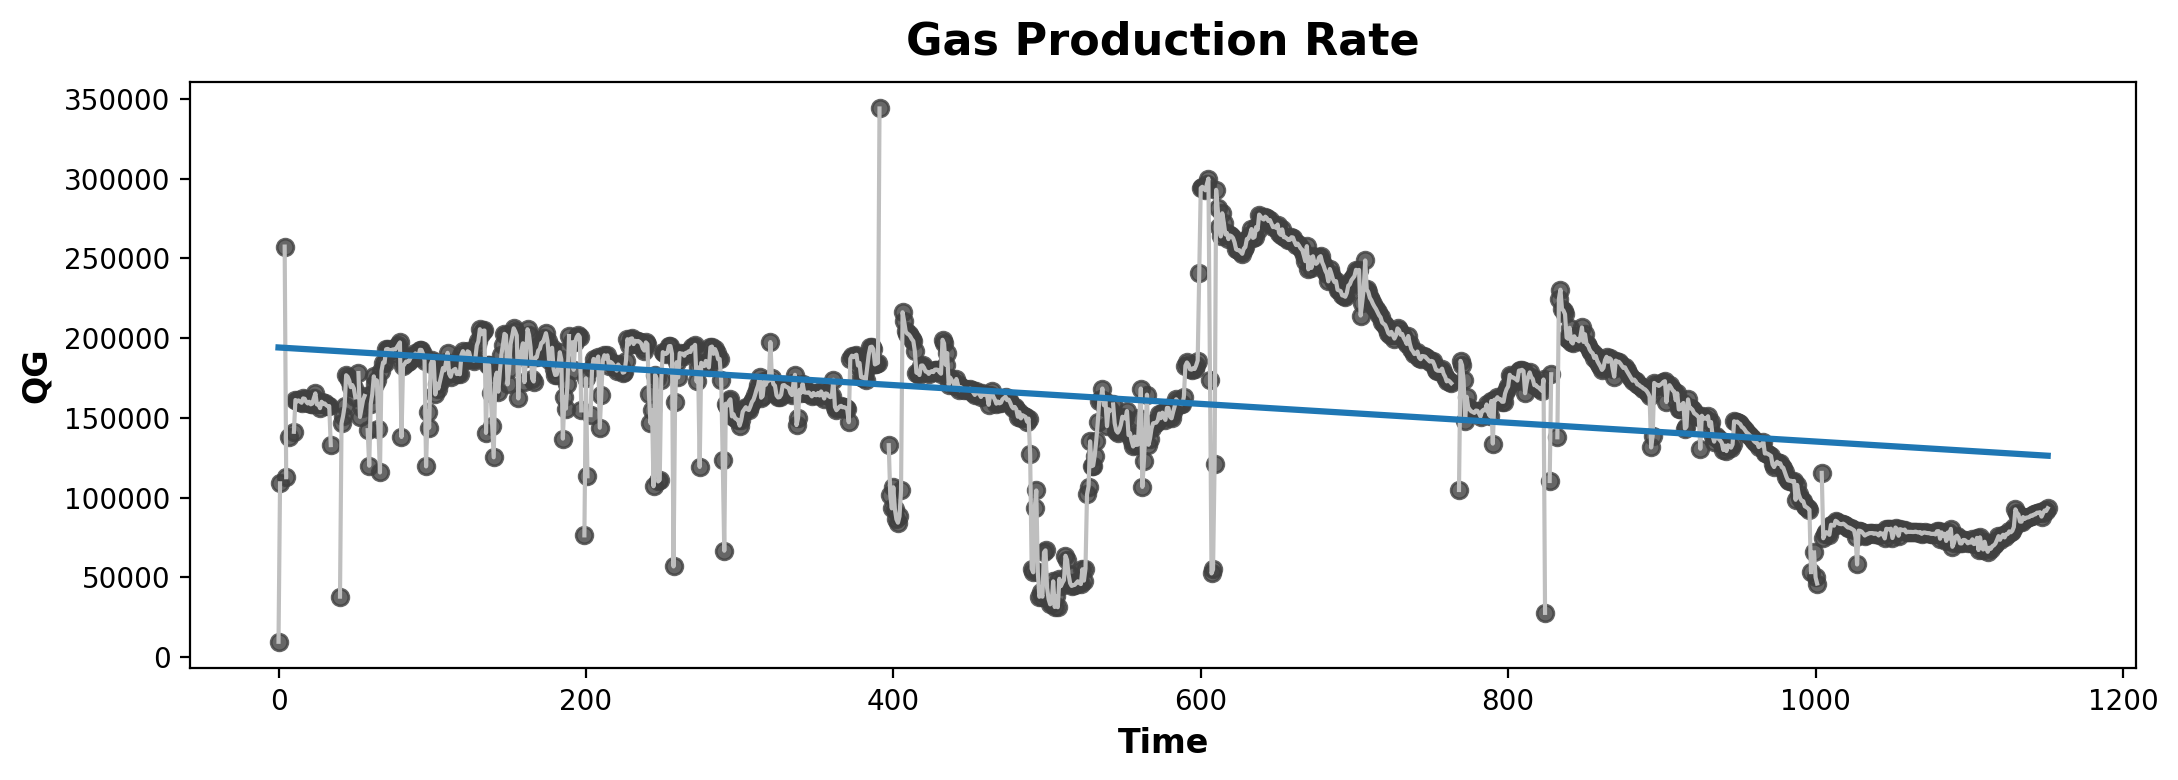

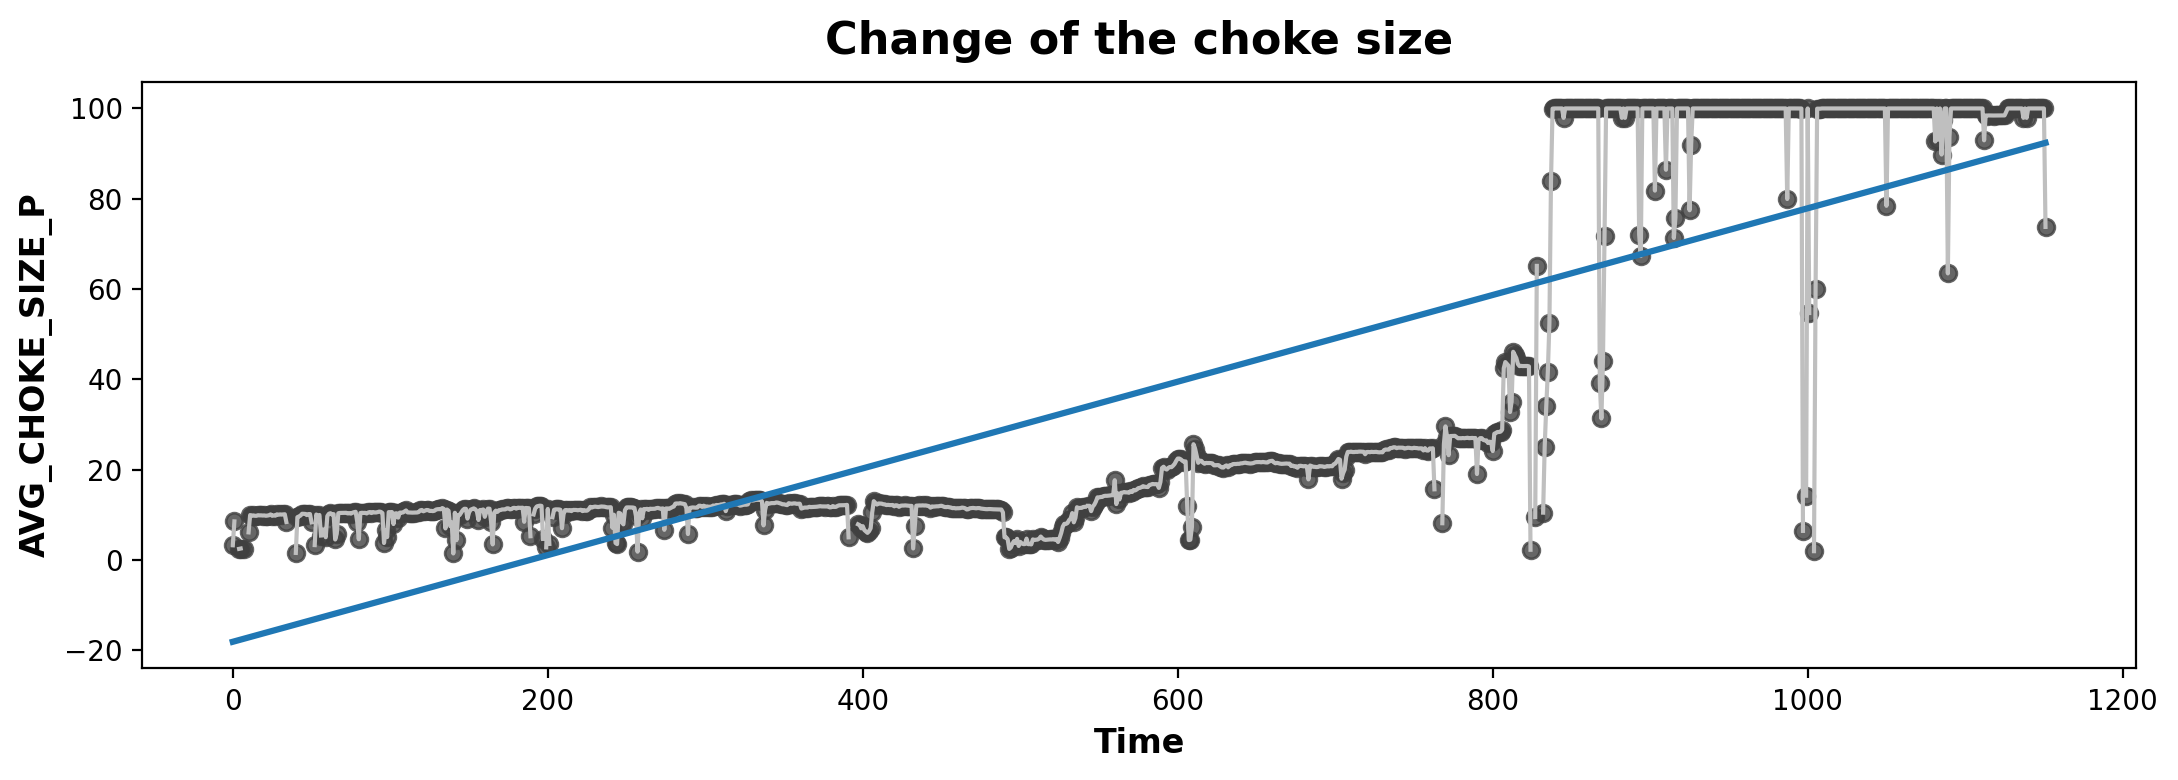

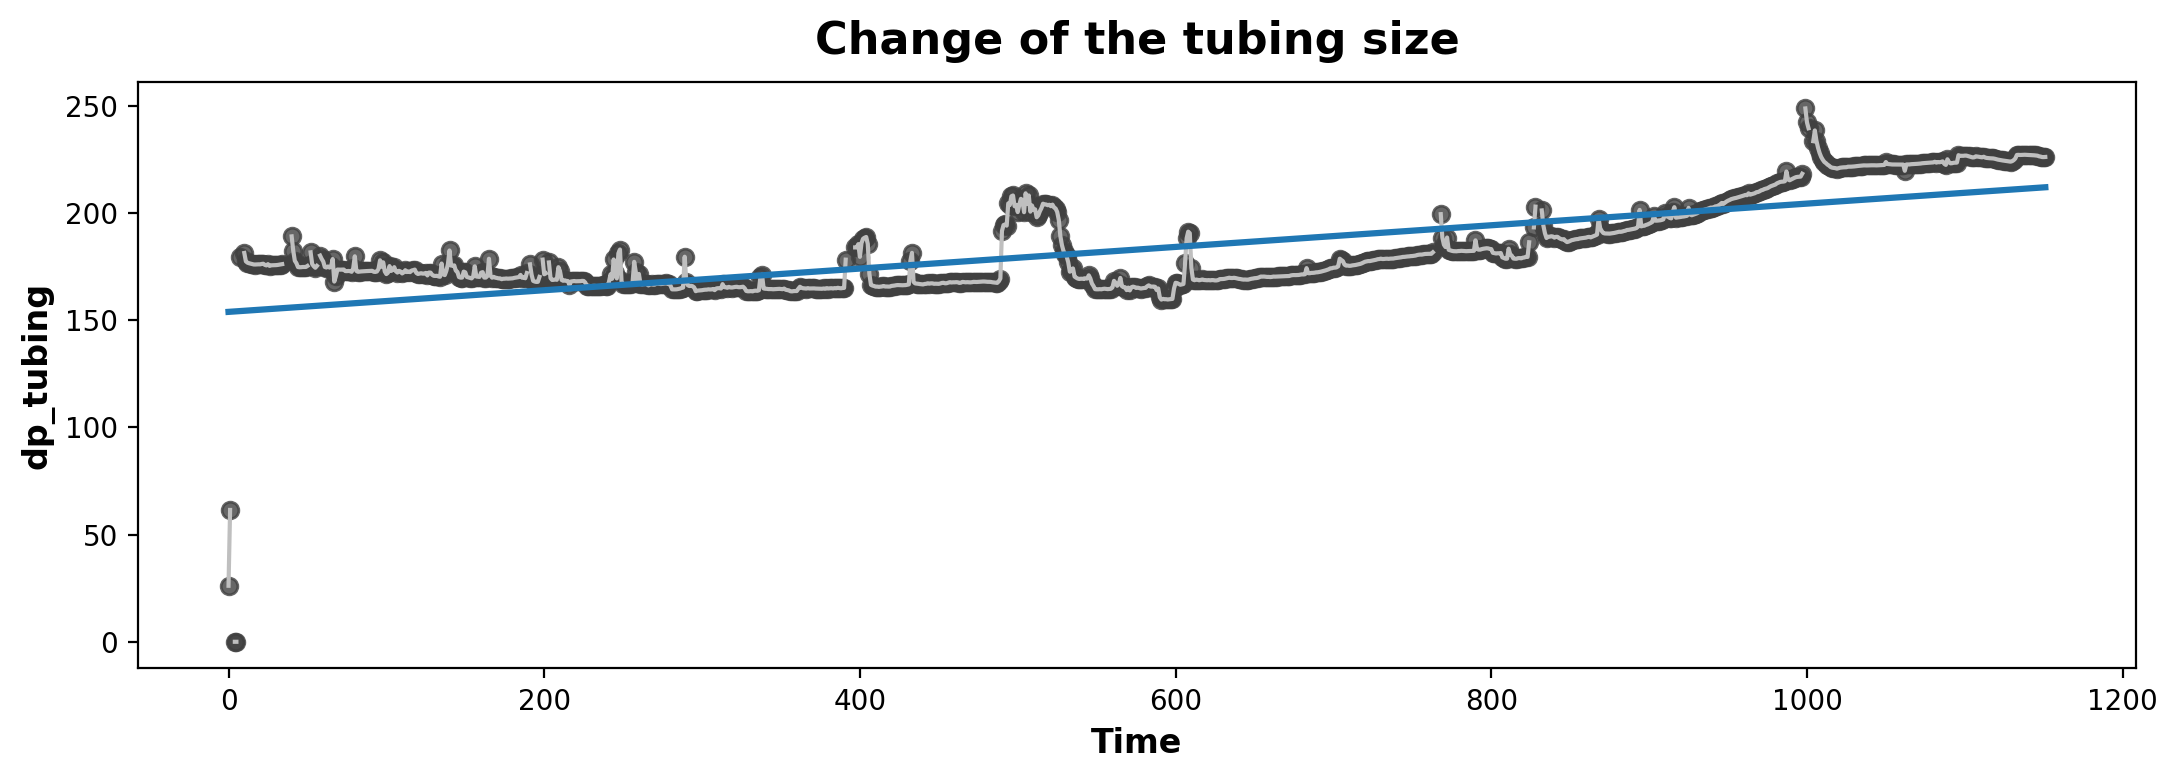

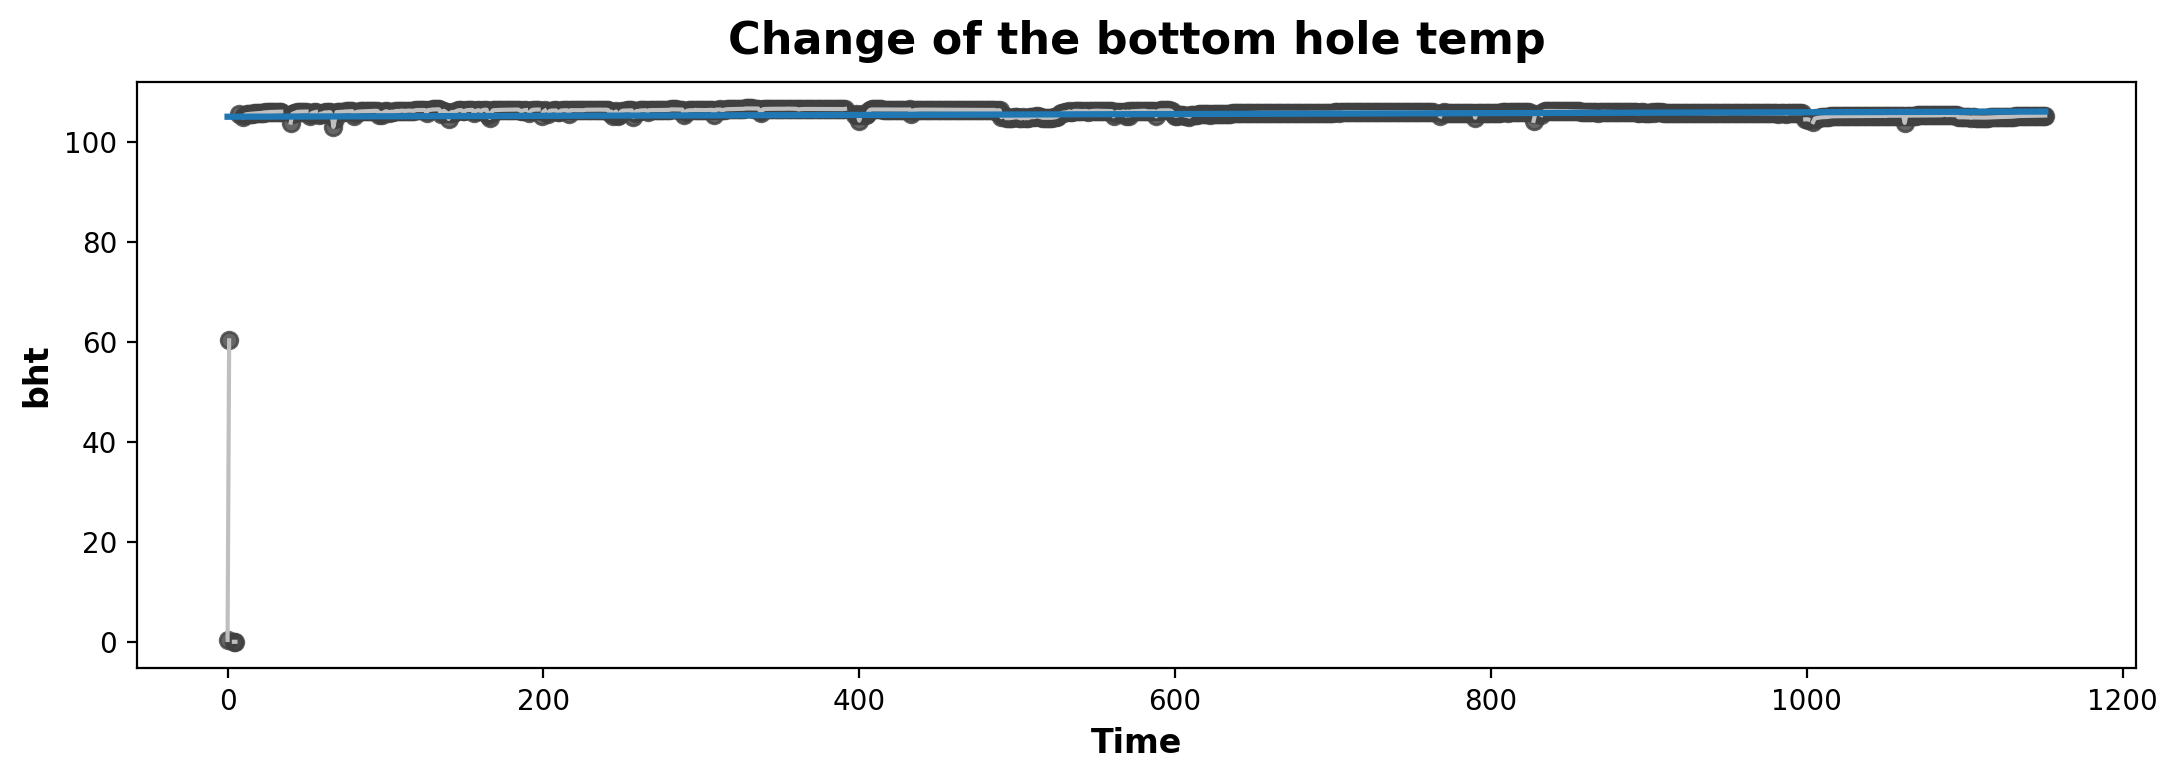

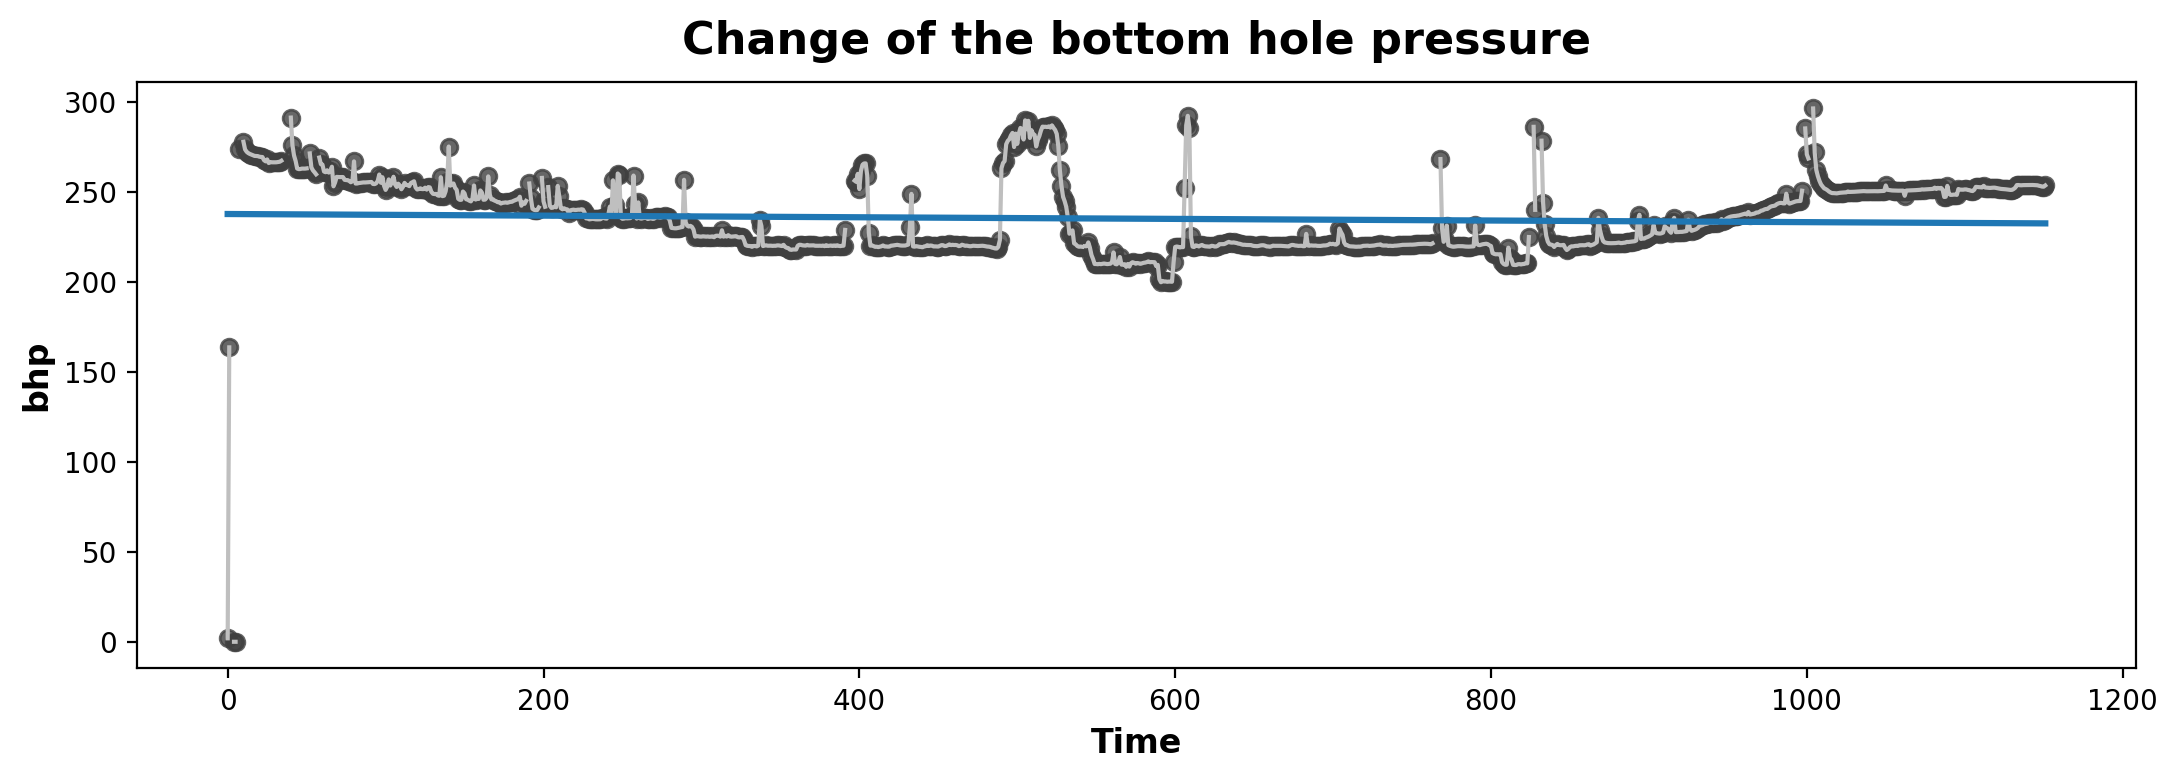

In [21]:
# Define a list of column names and their titles
plot_columns = [
    ('QG', 'Gas Production Rate'),
    ('AVG_CHOKE_SIZE_P', 'Change of the choke size'),
    ('dp_tubing', 'Change of the tubing size'),
    ('bht', 'Change of the bottom hole temp'),
    ('bhp', 'Change of the bottom hole pressure')
]

# Loop through each column and plot
for column, title in plot_columns:
    fig, ax = plt.subplots()
    ax.plot('Time', column, data=df, color='0.75')
    ax = sns.regplot(x='Time', y=column, data=df, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title(title)
    plt.show()

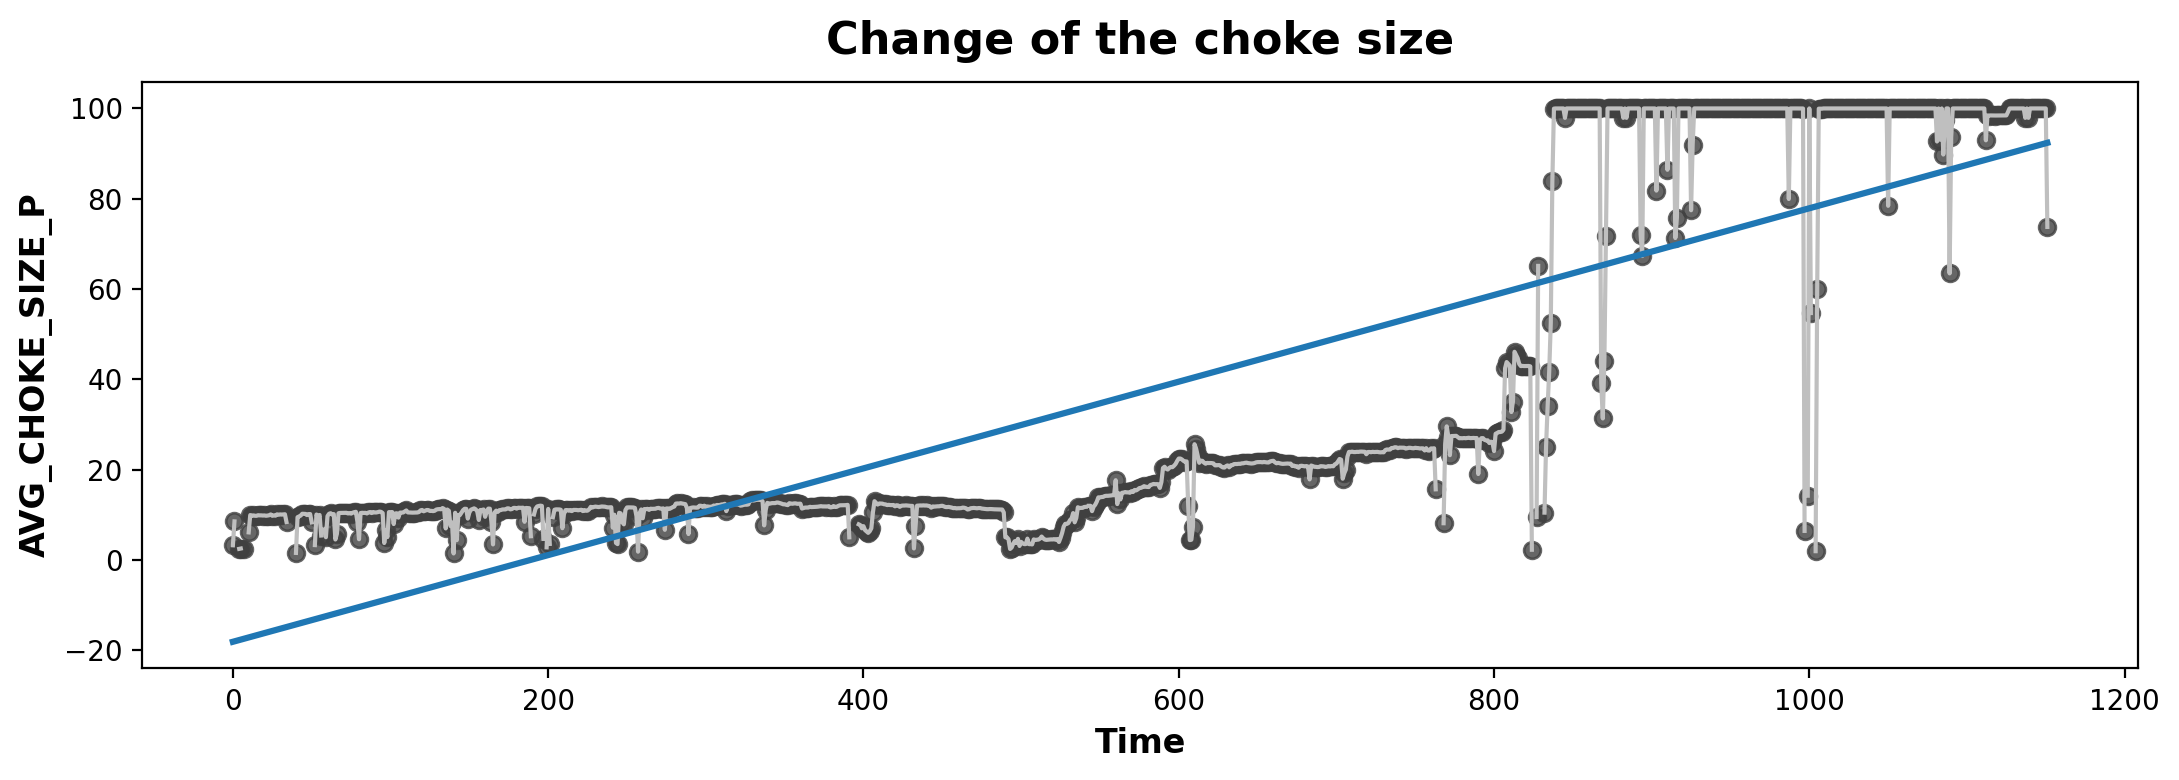

In [12]:
fig, ax = plt.subplots()
ax.plot('Time', 'AVG_CHOKE_SIZE_P', data=df, color='0.75')
ax = sns.regplot(x='Time', y='AVG_CHOKE_SIZE_P', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Change of the choke size');

Text(0.5, 1.0, 'Change of the tubing size')

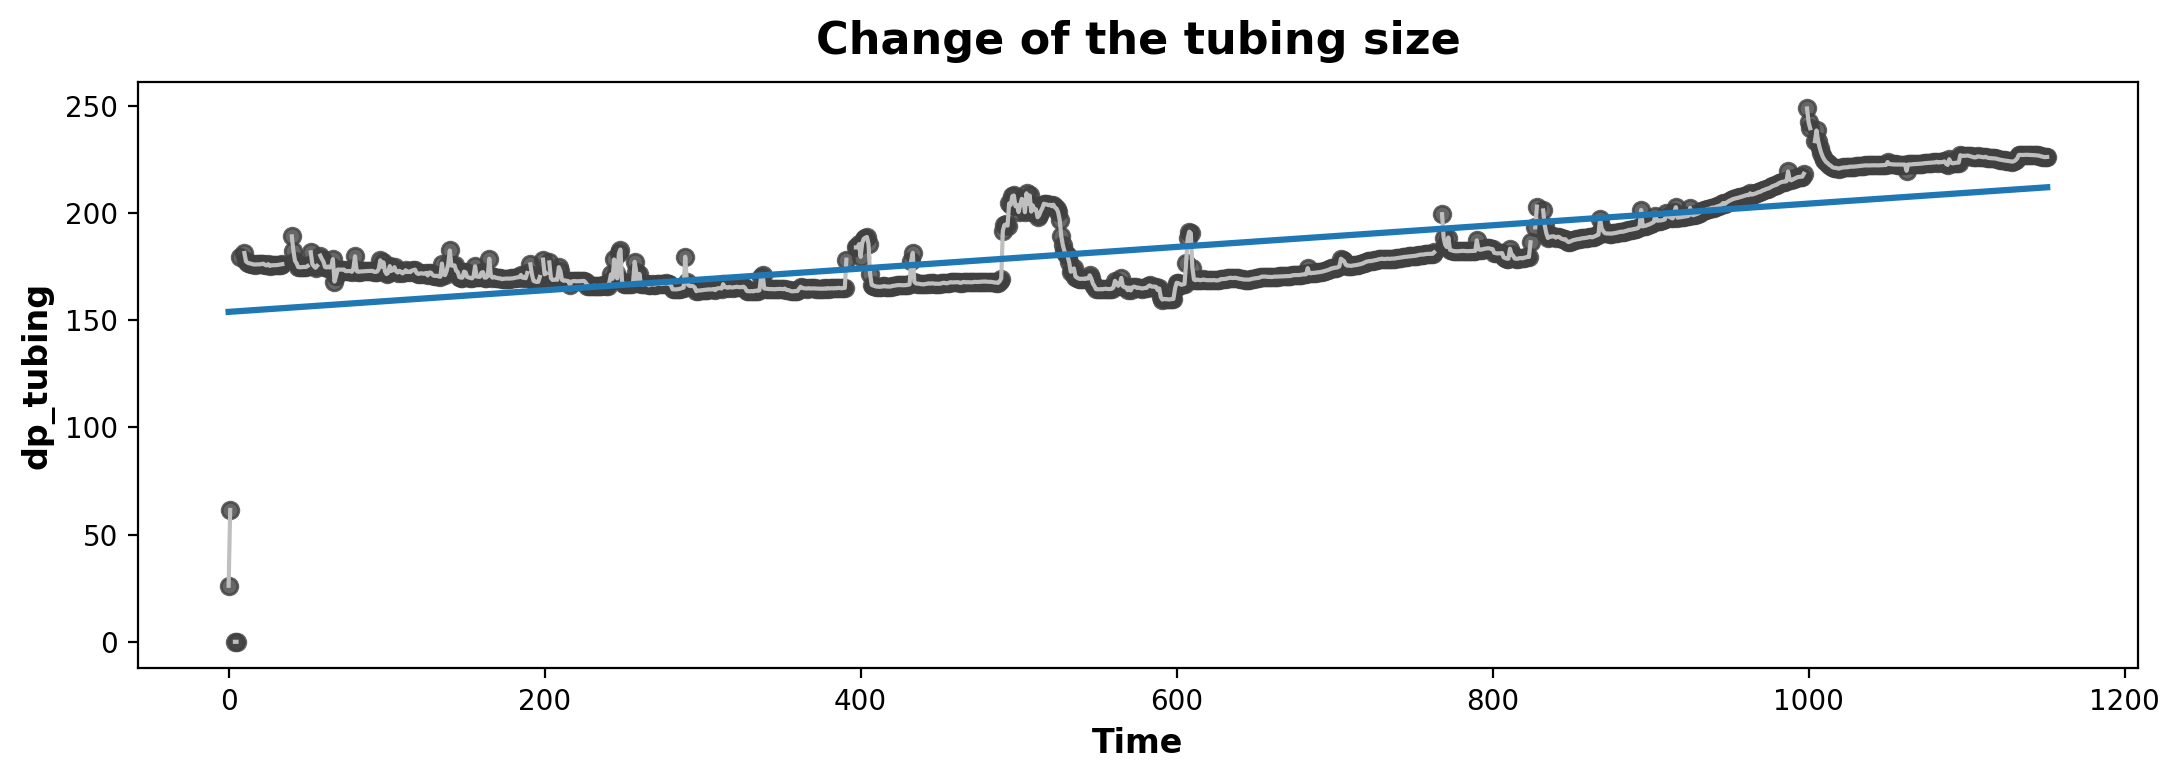

In [13]:
fig, ax = plt.subplots()
ax.plot('Time', "dp_tubing", data=df, color='0.75')
ax = sns.regplot(x='Time', y="dp_tubing", data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Change of the tubing size')

Text(0.5, 1.0, 'Change of the bottm hole temp')

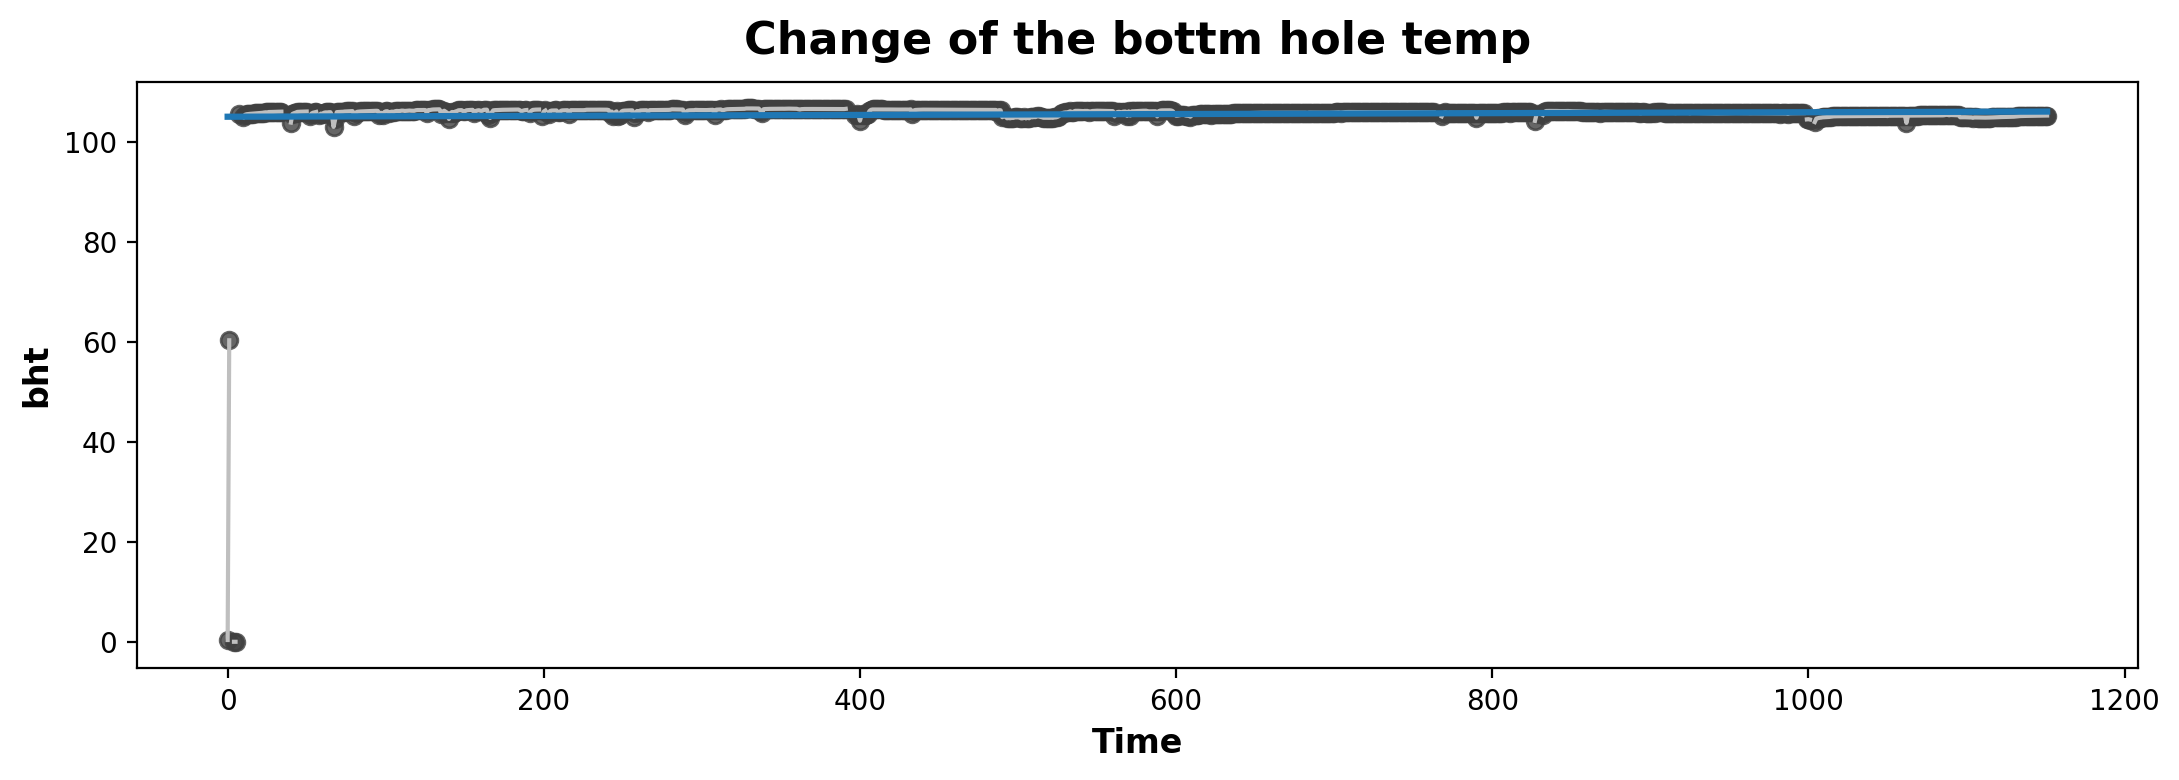

In [14]:
fig, ax = plt.subplots()
ax.plot('Time', "bht", data=df, color='0.75')
ax = sns.regplot(x='Time', y="bht", data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Change of the bottm hole temp')

Text(0.5, 1.0, 'Change of the bottm hole temp')

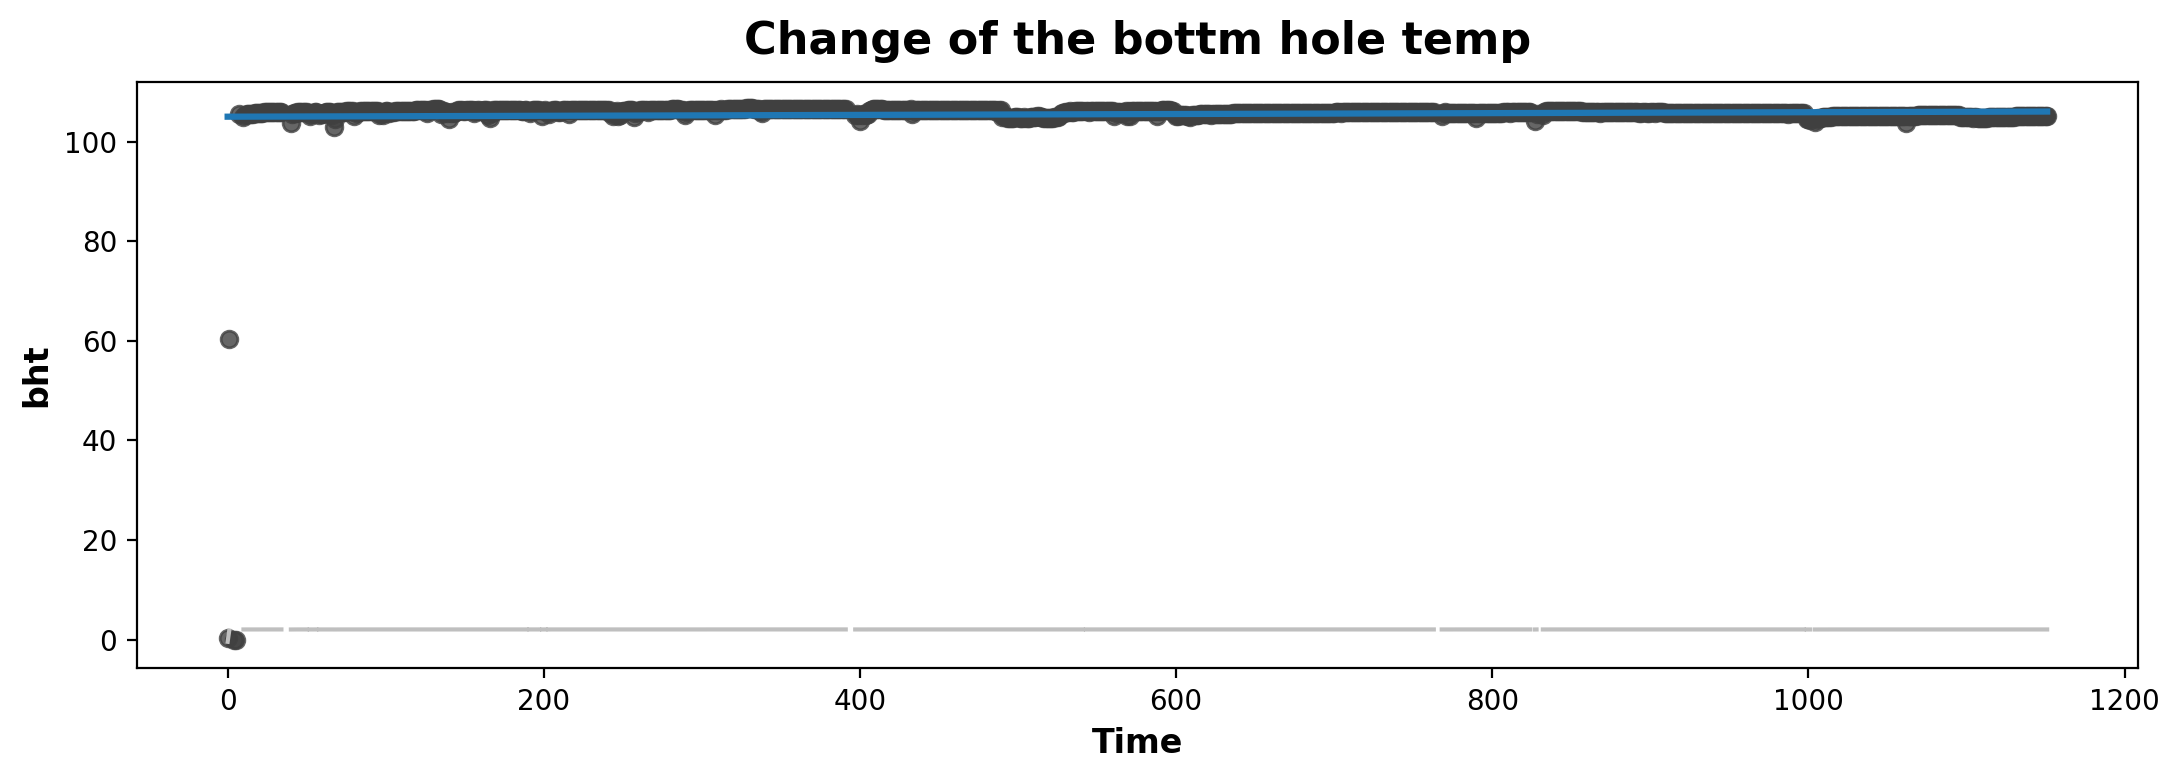

In [15]:
fig, ax = plt.subplots()
ax.plot('Time', "log_bht", data=df, color='0.75')
ax = sns.regplot(x='Time', y="bht", data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Change of the bottm hole temp')

Text(0.5, 1.0, 'Change of the bottm hole pressure')

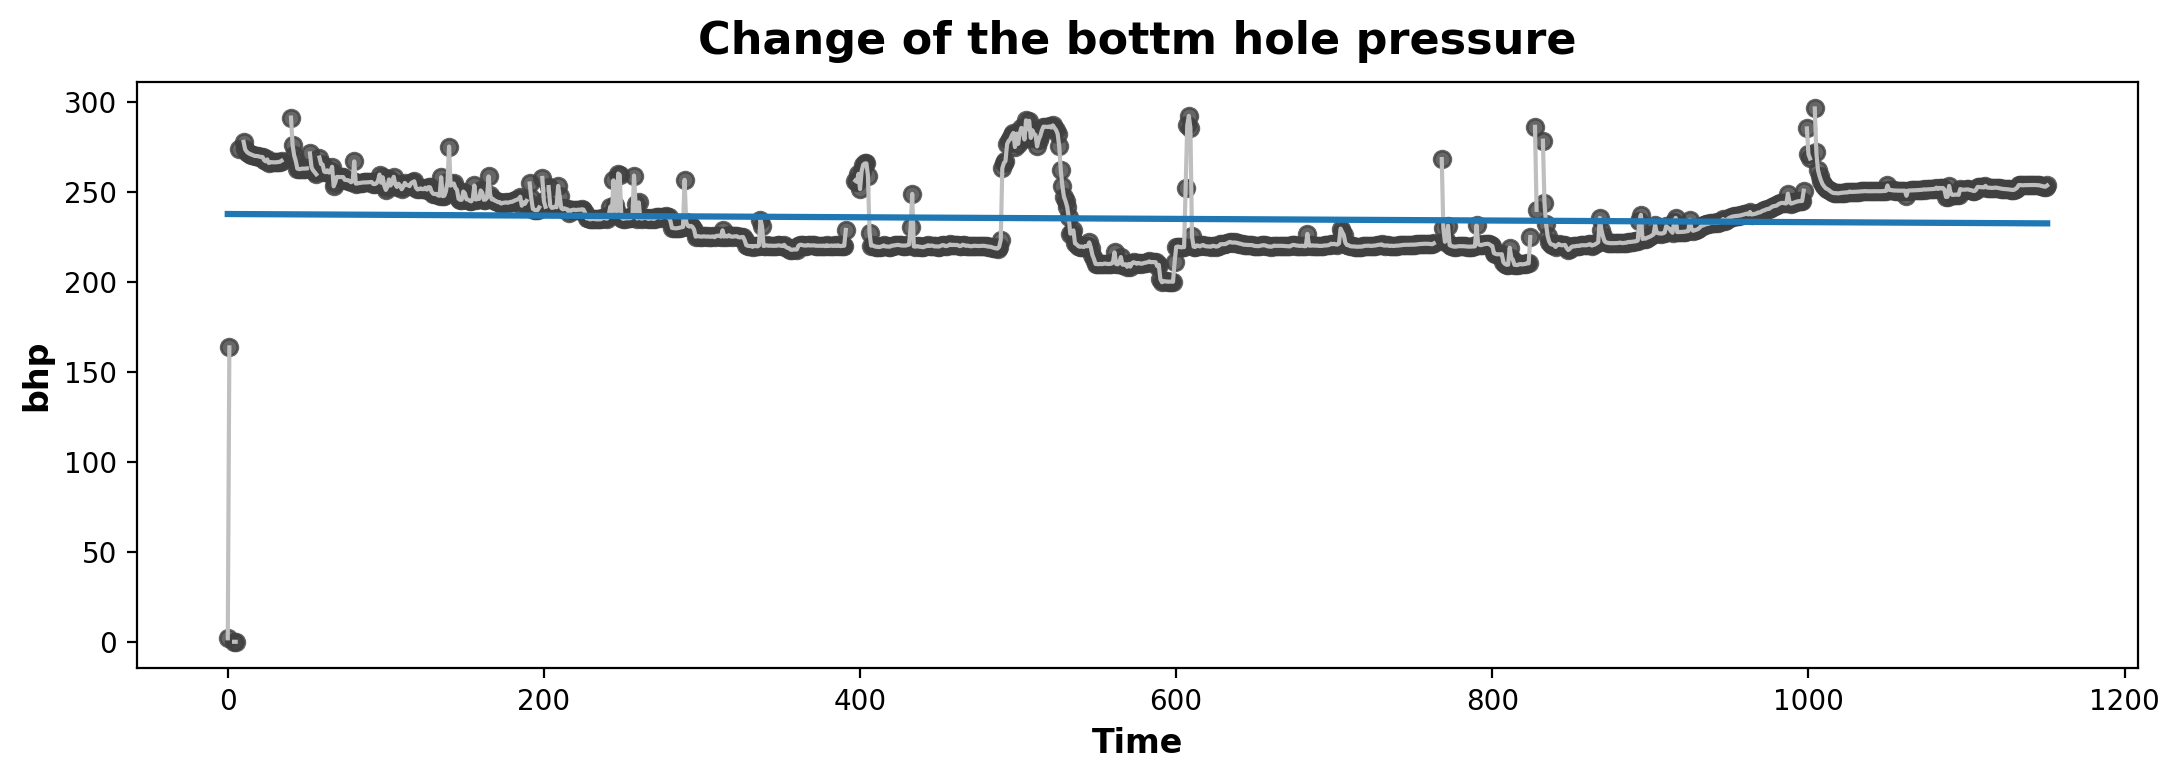

In [16]:
fig, ax = plt.subplots()
ax.plot('Time', "bhp", data=df, color='0.75')
ax = sns.regplot(x='Time', y="bhp", data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Change of the bottm hole pressure')

In [17]:
# add the lag
df["Lag_1"] = df["QG"].shift(1)
df.dropna(inplace=True)

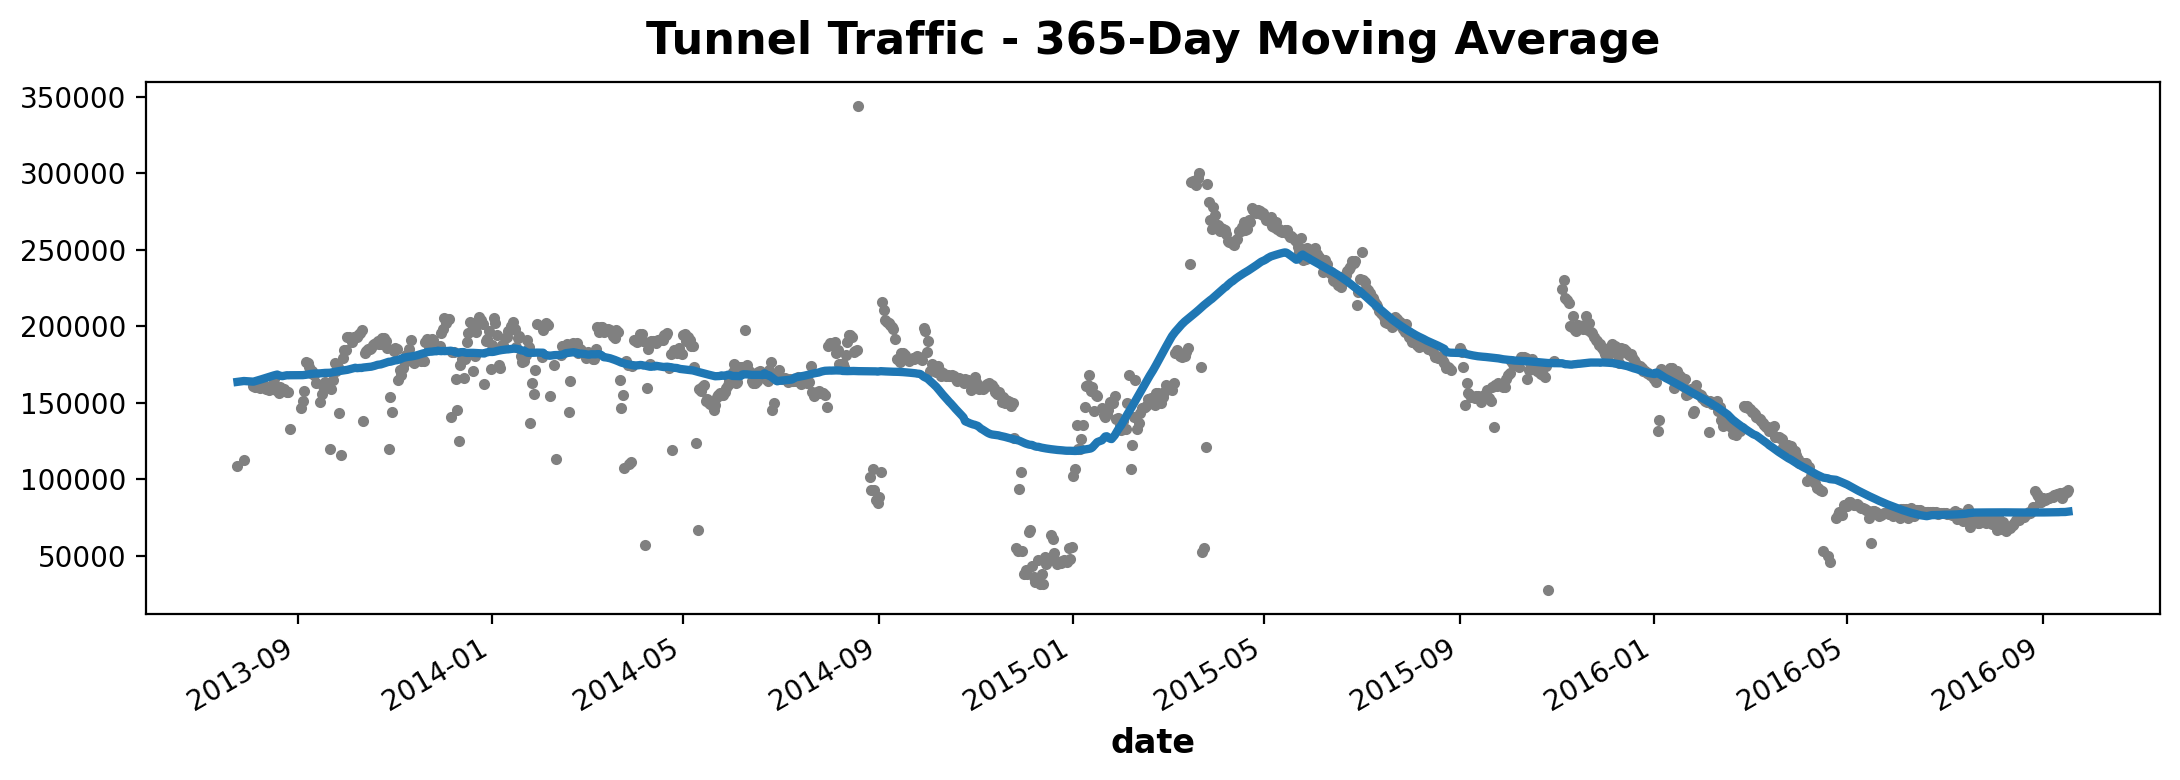

In [18]:
moving_average = df["QG"].rolling(
    window=120,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=30,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df["QG"].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In [19]:
df.head()

bhp         bht   dp_tubing  AVG_CHOKE_SIZE_P         QG  \
date                                                                          
2013-07-25  163.594260   60.315740   61.473080          8.549131  108940.11   
2013-07-29    0.000000    0.000000    0.000000          2.536987  112755.00   
2013-08-04  273.594368  105.439765  177.392876          9.951288  161227.00   
2013-08-05  272.298494  105.537800  176.786078          9.758748  160270.49   
2013-08-06  271.560953  105.584750  176.519376          9.882110  160951.30   

            Time   log_bht          Lag_1  
date                                       
2013-07-25     1  1.780431    9505.611429  
2013-07-29     5      -inf  257479.142857  
2013-08-04    11  2.023004  141268.448264  
2013-08-05    12  2.023408  161227.000000  
2013-08-06    13  2.023601  160270.490000

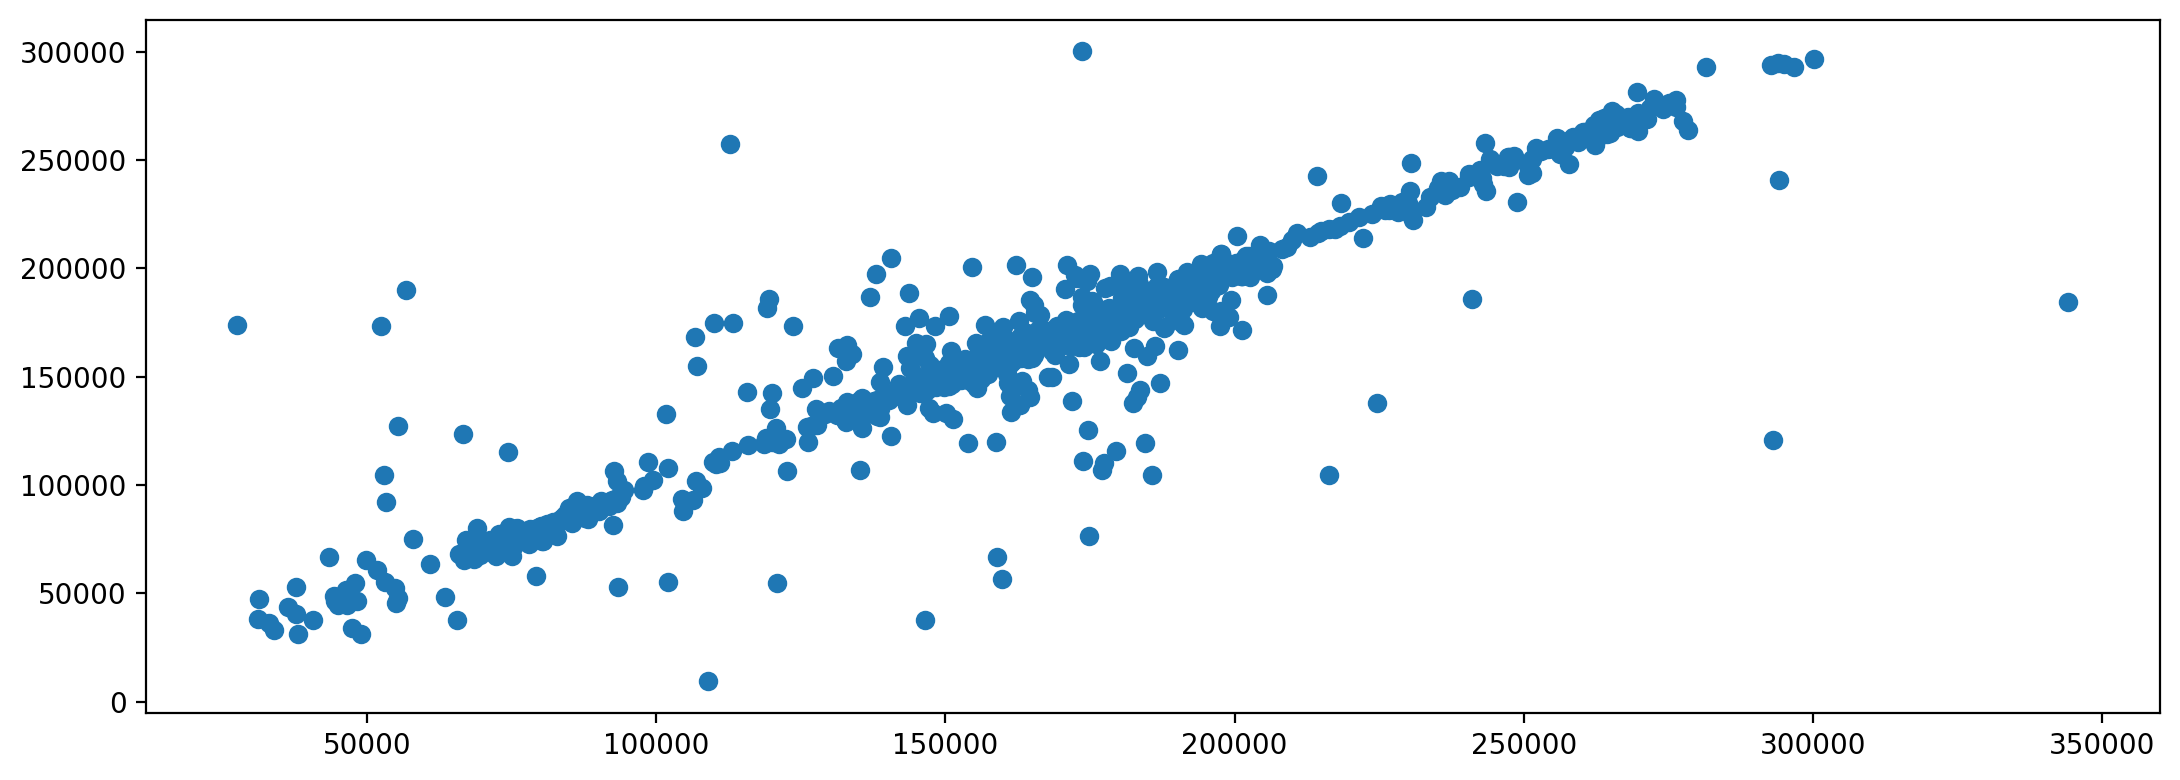

In [20]:
plt.scatter(df["QG"], df["Lag_1"])

In [21]:
X = df.copy()
X.pop("log_bht")
y = X.pop("QG")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [22]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
# mi_scores[::3]  # show a few features with their MI scores
mi_scores

Time                2.053508
Lag_1               2.015005
dp_tubing           1.515478
bhp                 1.158427
bht                 1.102903
AVG_CHOKE_SIZE_P    0.986008
Name: MI Scores, dtype: float64

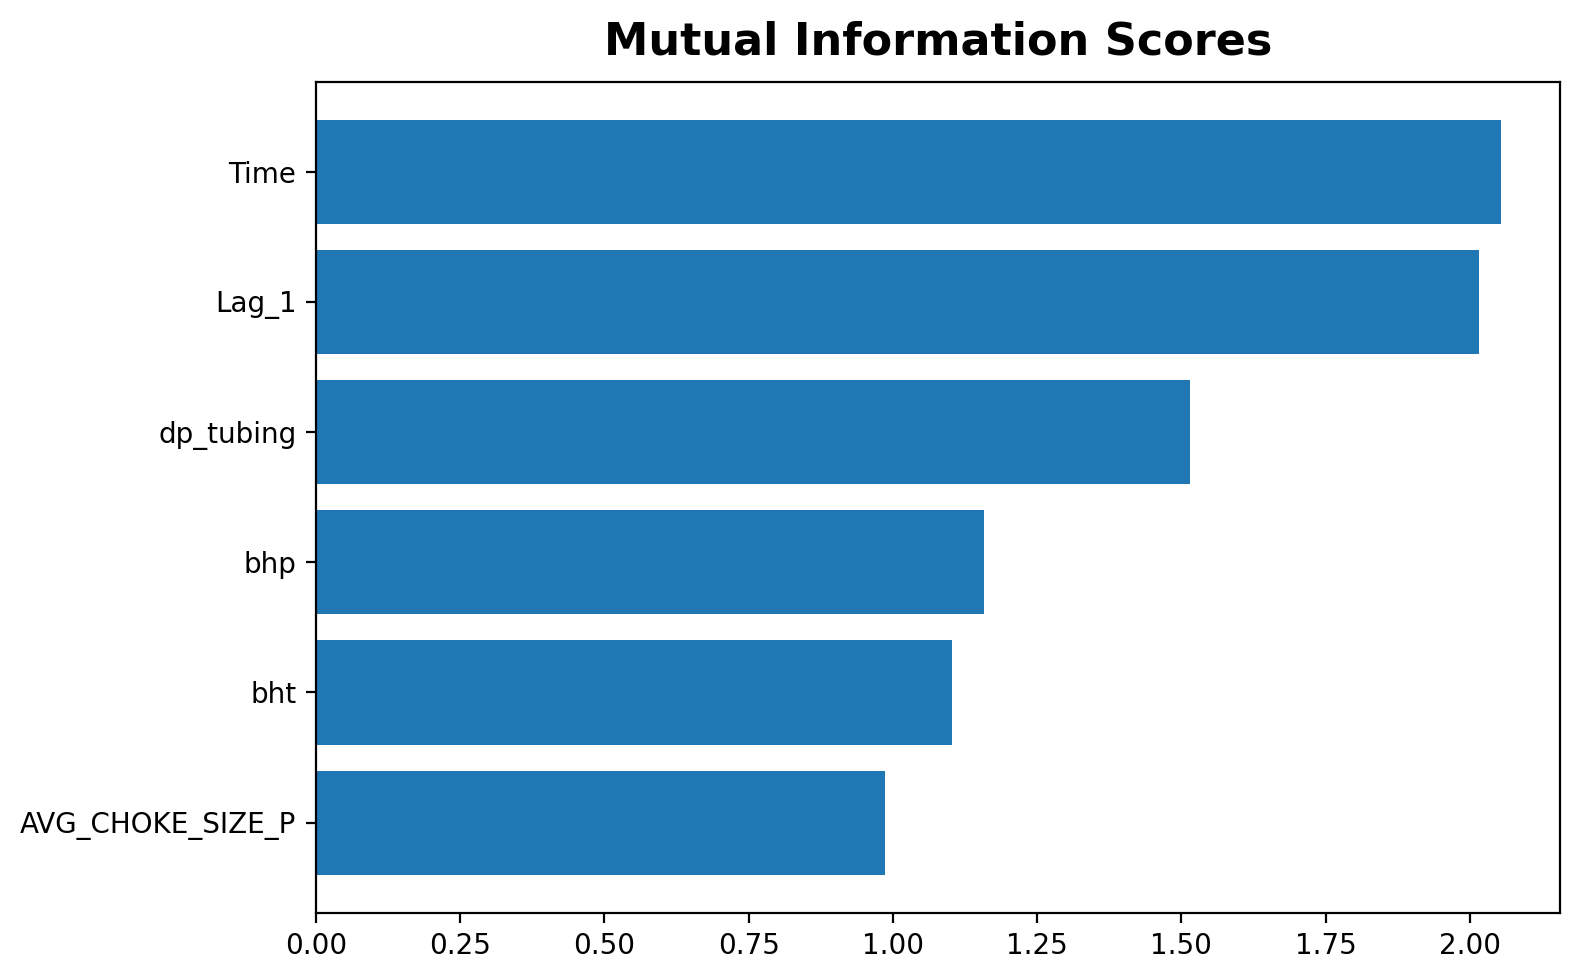

In [23]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

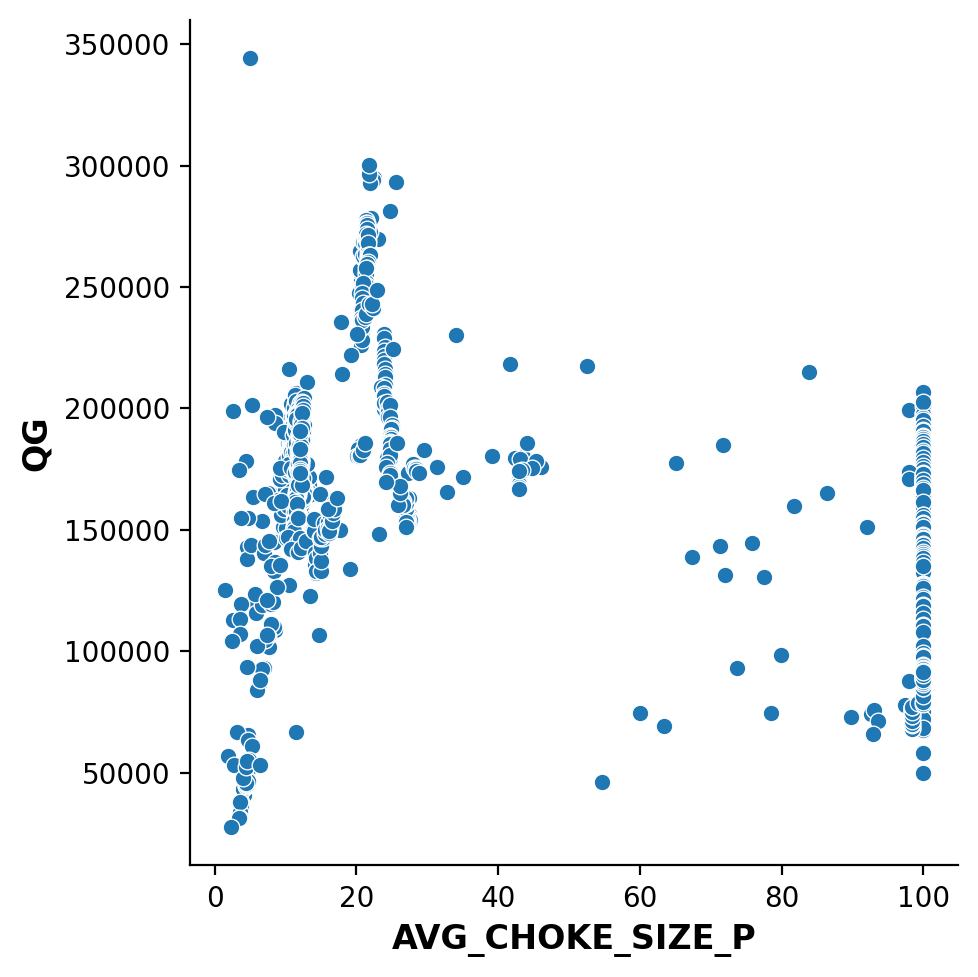

In [24]:
sns.relplot(x="AVG_CHOKE_SIZE_P", y="QG", data=df);

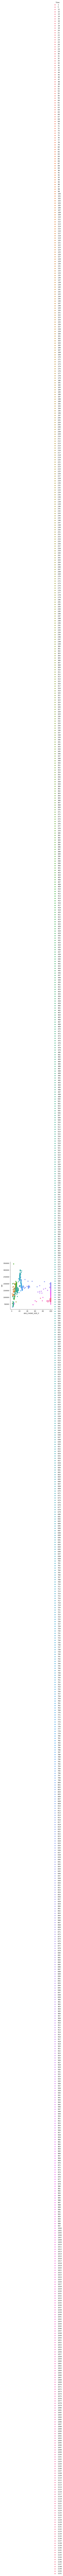

In [65]:
sns.lmplot(x="AVG_CHOKE_SIZE_P", y="QG", hue="Time", data=df)

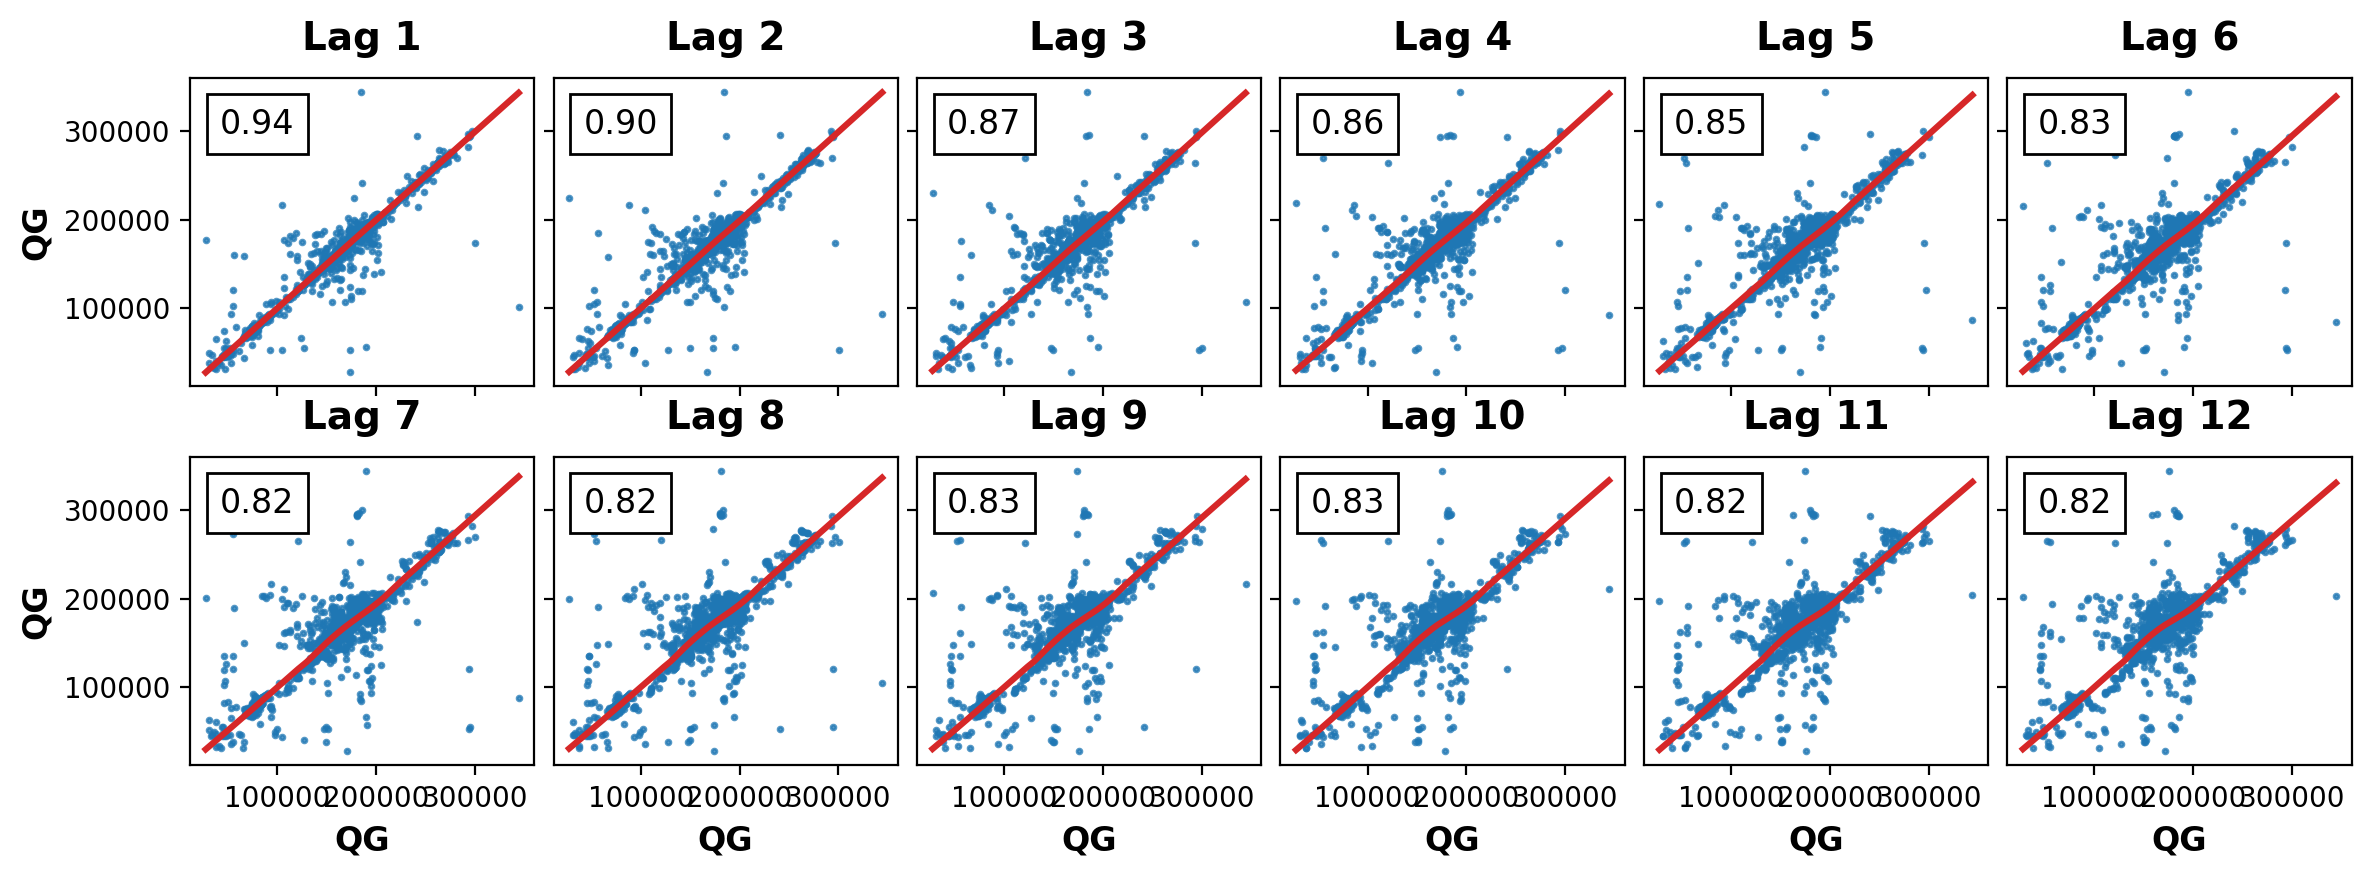

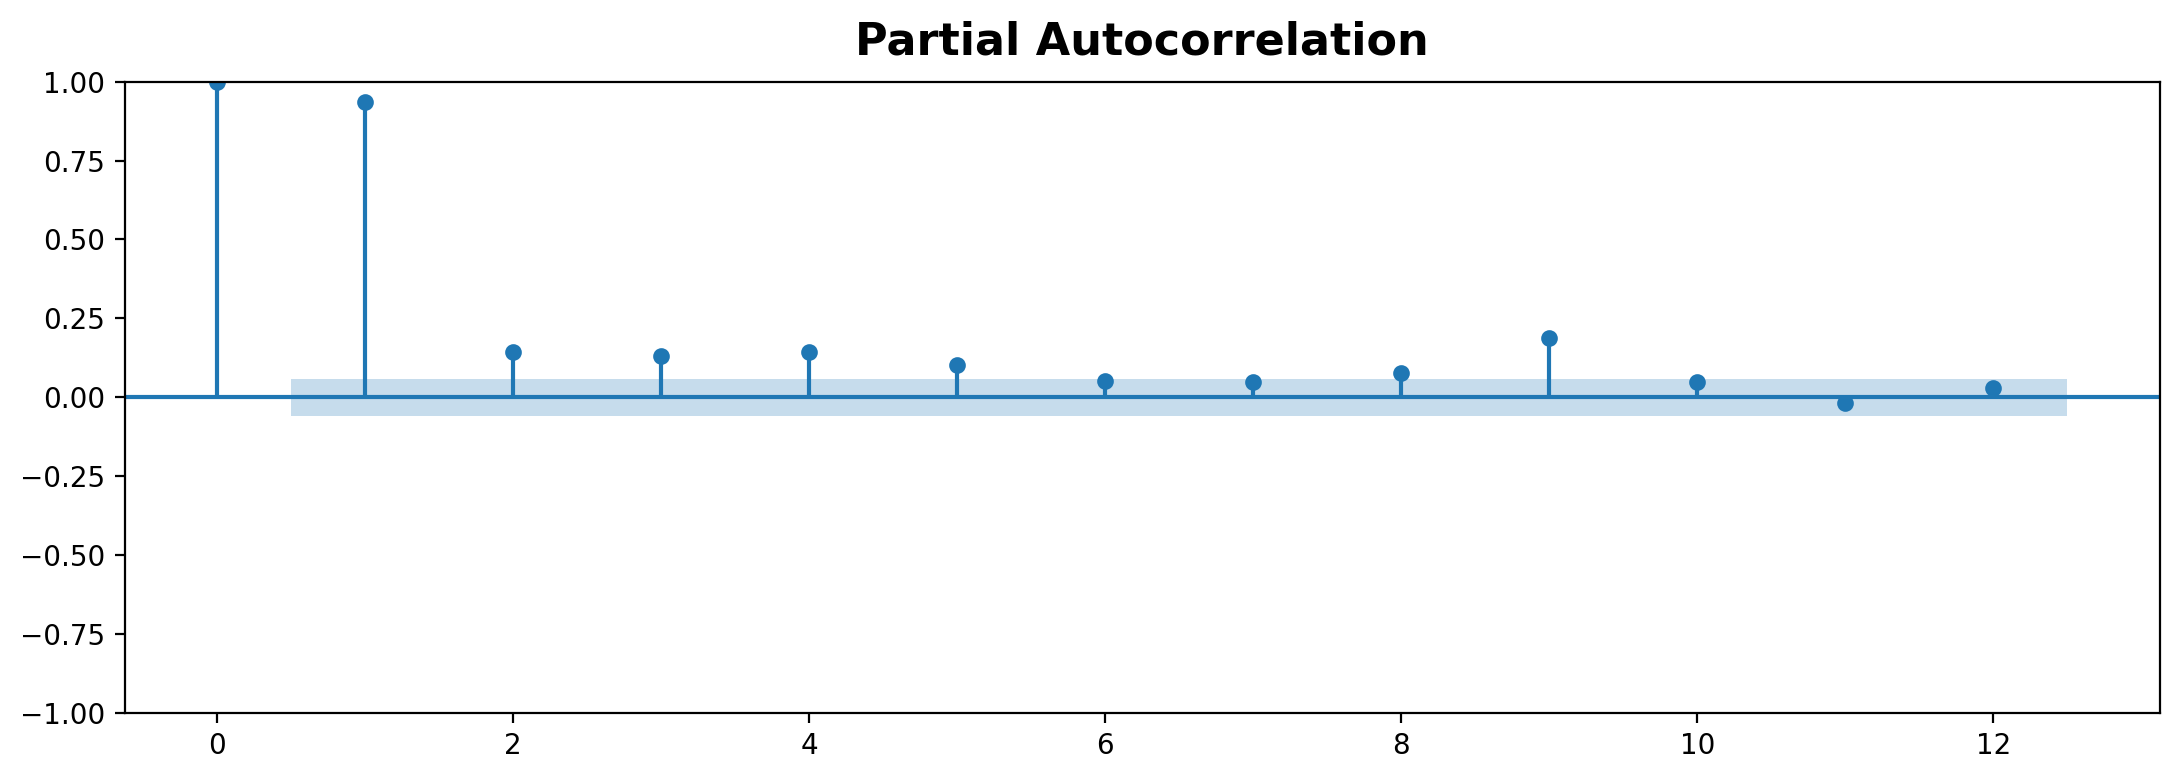

In [25]:
_ = plot_lags(df["QG"], lags=12, nrows=2)
_ = plot_pacf(df["QG"], lags=12)

In [26]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df["QG"], lags=4)
X = X.fillna(0.0)

In [27]:
# Create target series and data splits
y = df.QG.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

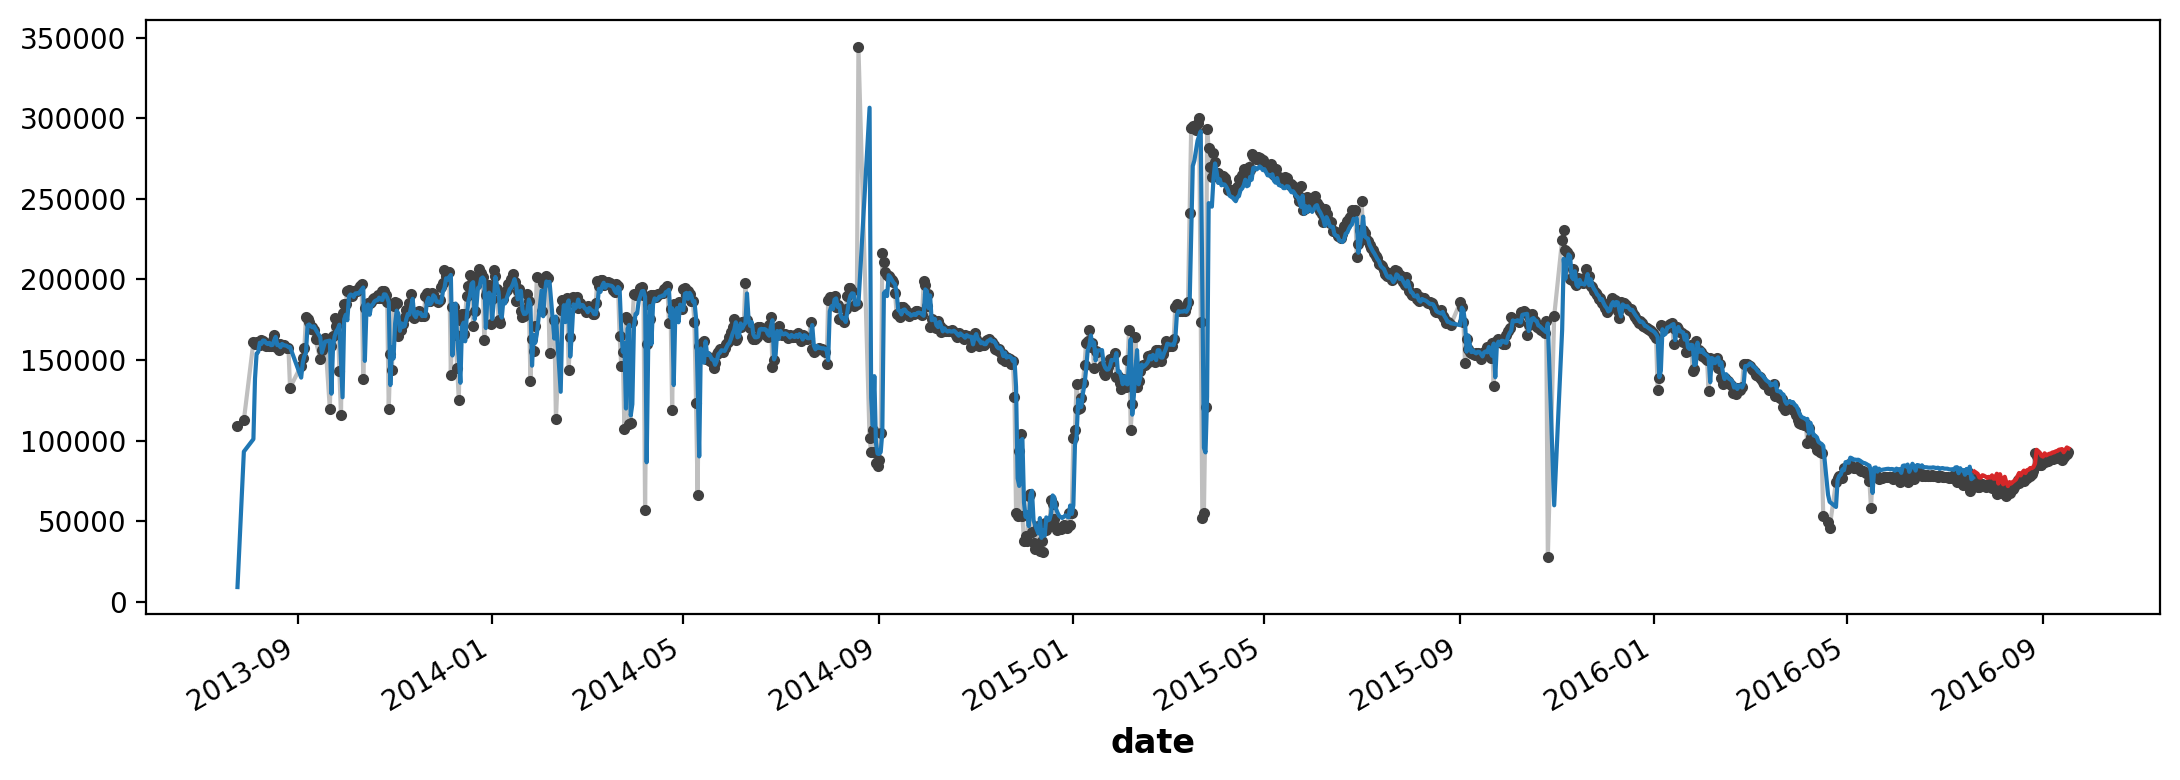

In [28]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

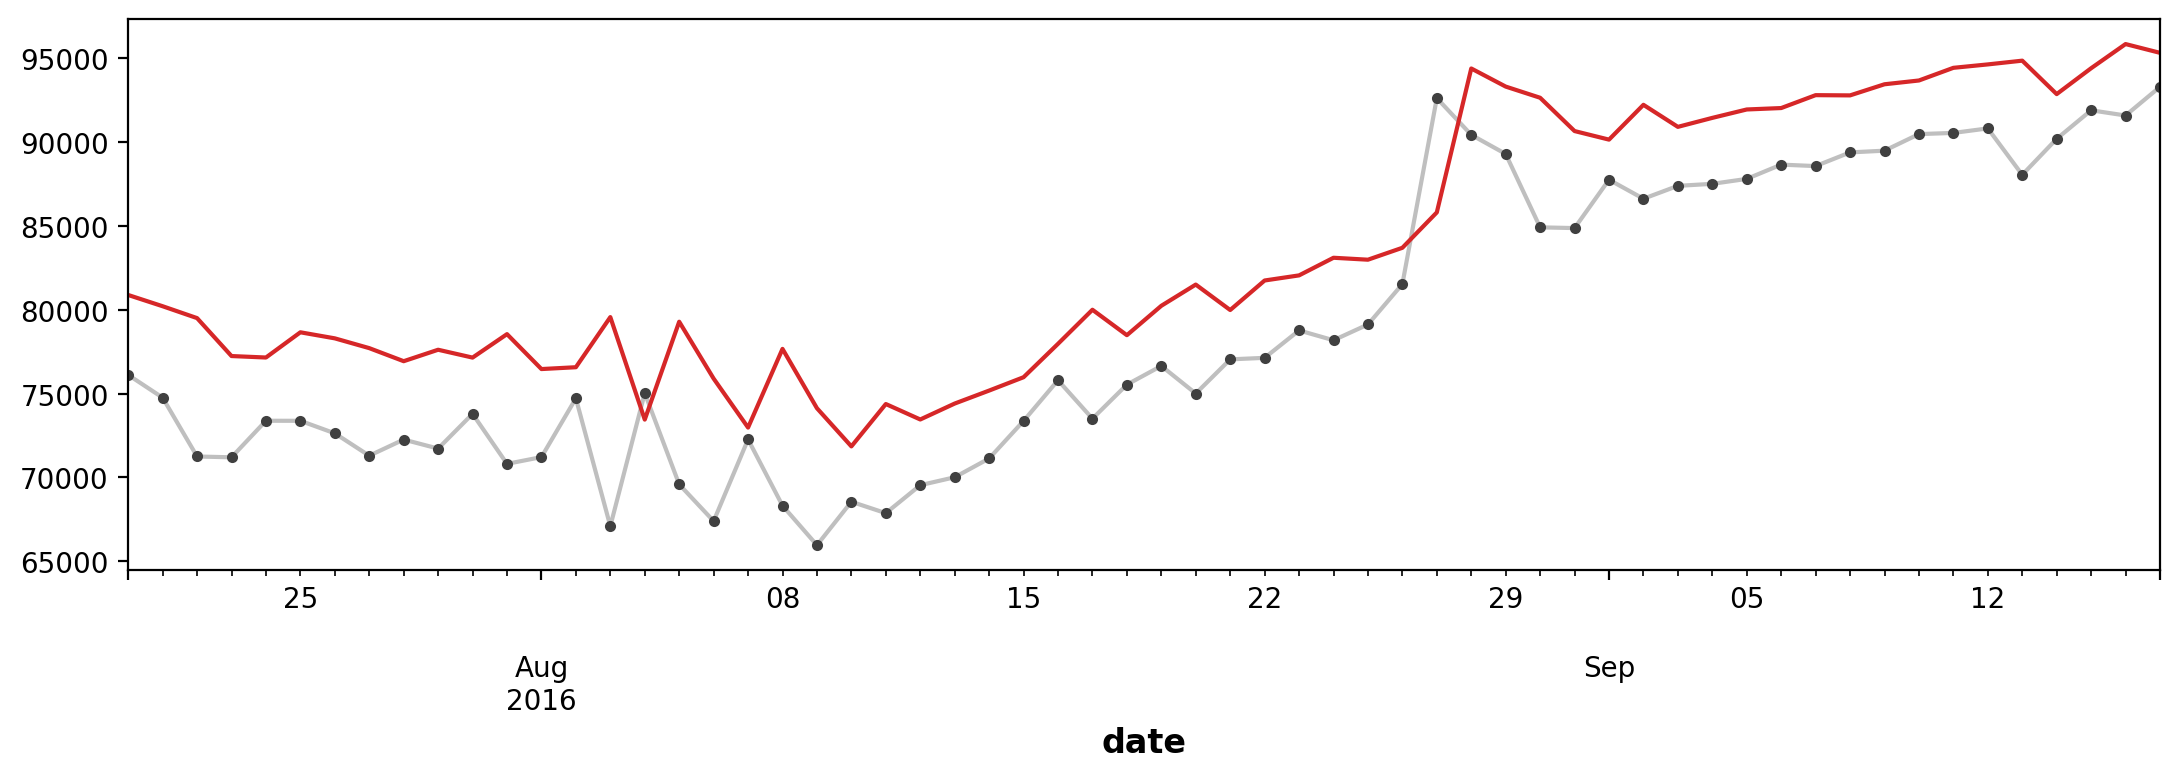

In [29]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

In [30]:
search_terms = ["bhp", "bht", "dp_tubing", "AVG_CHOKE_SIZE_P", "Time"]

# Create three lags for each search term
X0 = make_lags(df[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Create four lags for the target, as before
X1 = make_lags(df['QG'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)
X

y_lag_1 bhp  y_lag_1 bht  y_lag_1 dp_tubing  \
date                                                      
2013-07-25     0.000000     0.000000           0.000000   
2013-07-29   163.594260    60.315740          61.473080   
2013-08-04     0.000000     0.000000           0.000000   
2013-08-05   273.594368   105.439765         177.392876   
2013-08-06   272.298494   105.537800         176.786078   
...                 ...          ...                ...   
2016-09-13   253.658108   105.259036         226.680342   
2016-09-14   253.399422   105.266981         226.400814   
2016-09-15   253.209915   105.271539         226.255384   
2016-09-16   252.938710   105.274111         226.036656   
2016-09-17   252.892344   105.275896         226.022291   

            y_lag_1 AVG_CHOKE_SIZE_P  y_lag_1 Time  y_lag_2 bhp  y_lag_2 bht  \
date                                                                           
2013-07-25                  0.000000           0.0     0.000000     0.000000   
2013-07-29                  8.549131           1.0     0.000000     0.000000   
2013-08-04                  2.536987           5.0   163.594260    60.315740   
2013-08-05                  9.951288          11.0     0.000000     0.000000   
2013-08-06                  9.758748          12.0   273.594368   105.439765   
...                              ...           ...          ...          ...   
2016-09-13                100.000000        1146.0   253.730432   105.254879   
2016-09-14                100.000000        1147.0   253.658108   105.259036   
2016-09-15                100.000000        1148.0   253.399422   105.266981   
2016-09-16                100.000000        1149.0   253.209915   105.271539   
2016-09-17                100.000000        1150.0   252.938710   105.274111   

            y_lag_2 dp_tubing  y_lag_2 AVG_CHOKE_SIZE_P  y_lag_2 Time  \
date                                                                    
2013-07-25           0.000000                  0.000000           0.0   
2013-07-29           0.000000                  0.000000           0.0   
2013-08-04          61.473080                  8.549131           1.0   
2013-08-05           0.000000                  2.536987           5.0   
2013-08-06         177.392876                  9.951288          11.0   
...                       ...                       ...           ...   
2016-09-13         226.765975                100.000000        1145.0   
2016-09-14         226.680342                100.000000        1146.0   
2016-09-15         226.400814                100.000000        1147.0   
2016-09-16         226.255384                100.000000        1148.0   
2016-09-17         226.036656                100.000000        1149.0   

            y_lag_3 bhp  y_lag_3 bht  y_lag_3 dp_tubing  \
date                                                      
2013-07-25     0.000000     0.000000           0.000000   
2013-07-29     0.000000     0.000000           0.000000   
2013-08-04     0.000000     0.000000           0.000000   
2013-08-05   163.594260    60.315740          61.473080   
2013-08-06     0.000000     0.000000           0.000000   
...                 ...          ...                ...   
2016-09-13   253.748523   105.249351         226.848908   
2016-09-14   253.730432   105.254879         226.765975   
2016-09-15   253.658108   105.259036         226.680342   
2016-09-16   253.399422   105.266981         226.400814   
2016-09-17   253.209915   105.271539         226.255384   

            y_lag_3 AVG_CHOKE_SIZE_P  y_lag_3 Time    y_lag_1    y_lag_2  \
date                                                                       
2013-07-25                  0.000000           0.0       0.00       0.00   
2013-07-29                  0.000000           0.0  108940.11       0.00   
2013-08-04                  0.000000           0.0  112755.00  108940.11   
2013-08-05                  8.549131           1.0  161227.00  112755.00   
2013-08-06                  2

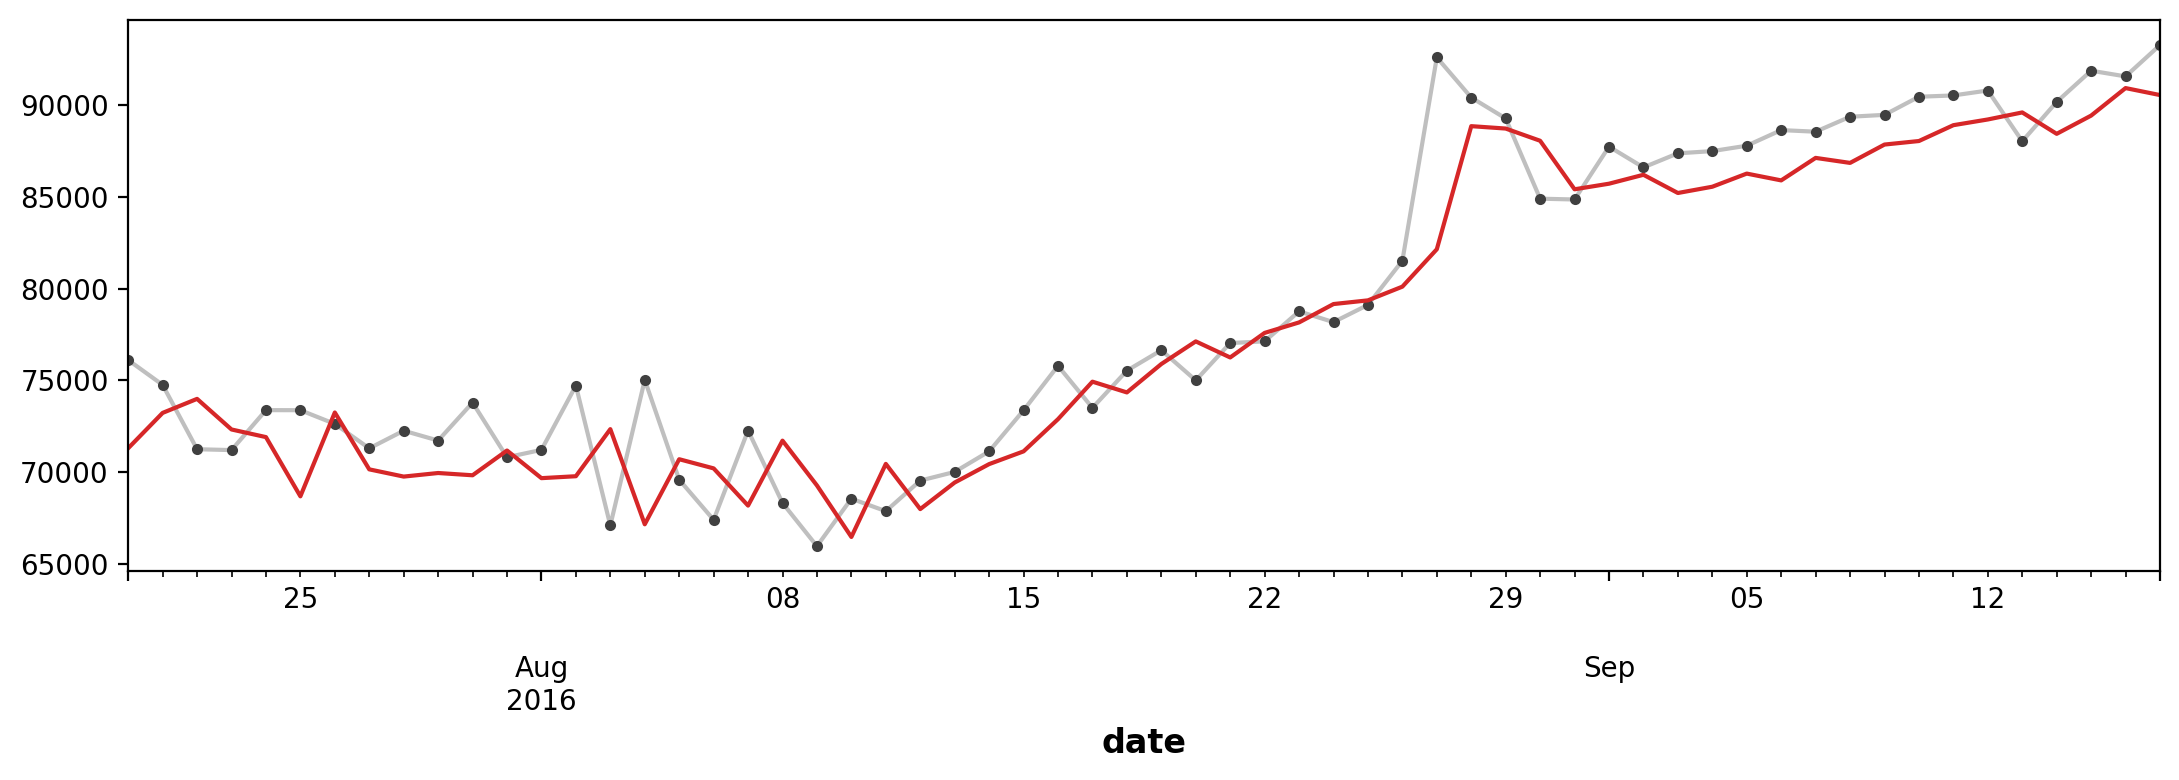

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

<h1>Hybrid Forcasting</h1>

In [33]:
# df.pop("log_bht")
df.pop("Lag_1")
df.head()

bhp         bht   dp_tubing  AVG_CHOKE_SIZE_P         QG  \
date                                                                          
2013-07-25  163.594260   60.315740   61.473080          8.549131  108940.11   
2013-07-29    0.000000    0.000000    0.000000          2.536987  112755.00   
2013-08-04  273.594368  105.439765  177.392876          9.951288  161227.00   
2013-08-05  272.298494  105.537800  176.786078          9.758748  160270.49   
2013-08-06  271.560953  105.584750  176.519376          9.882110  160951.30   

            Time  
date              
2013-07-25     1  
2013-07-29     5  
2013-08-04    11  
2013-08-05    12  
2013-08-06    13

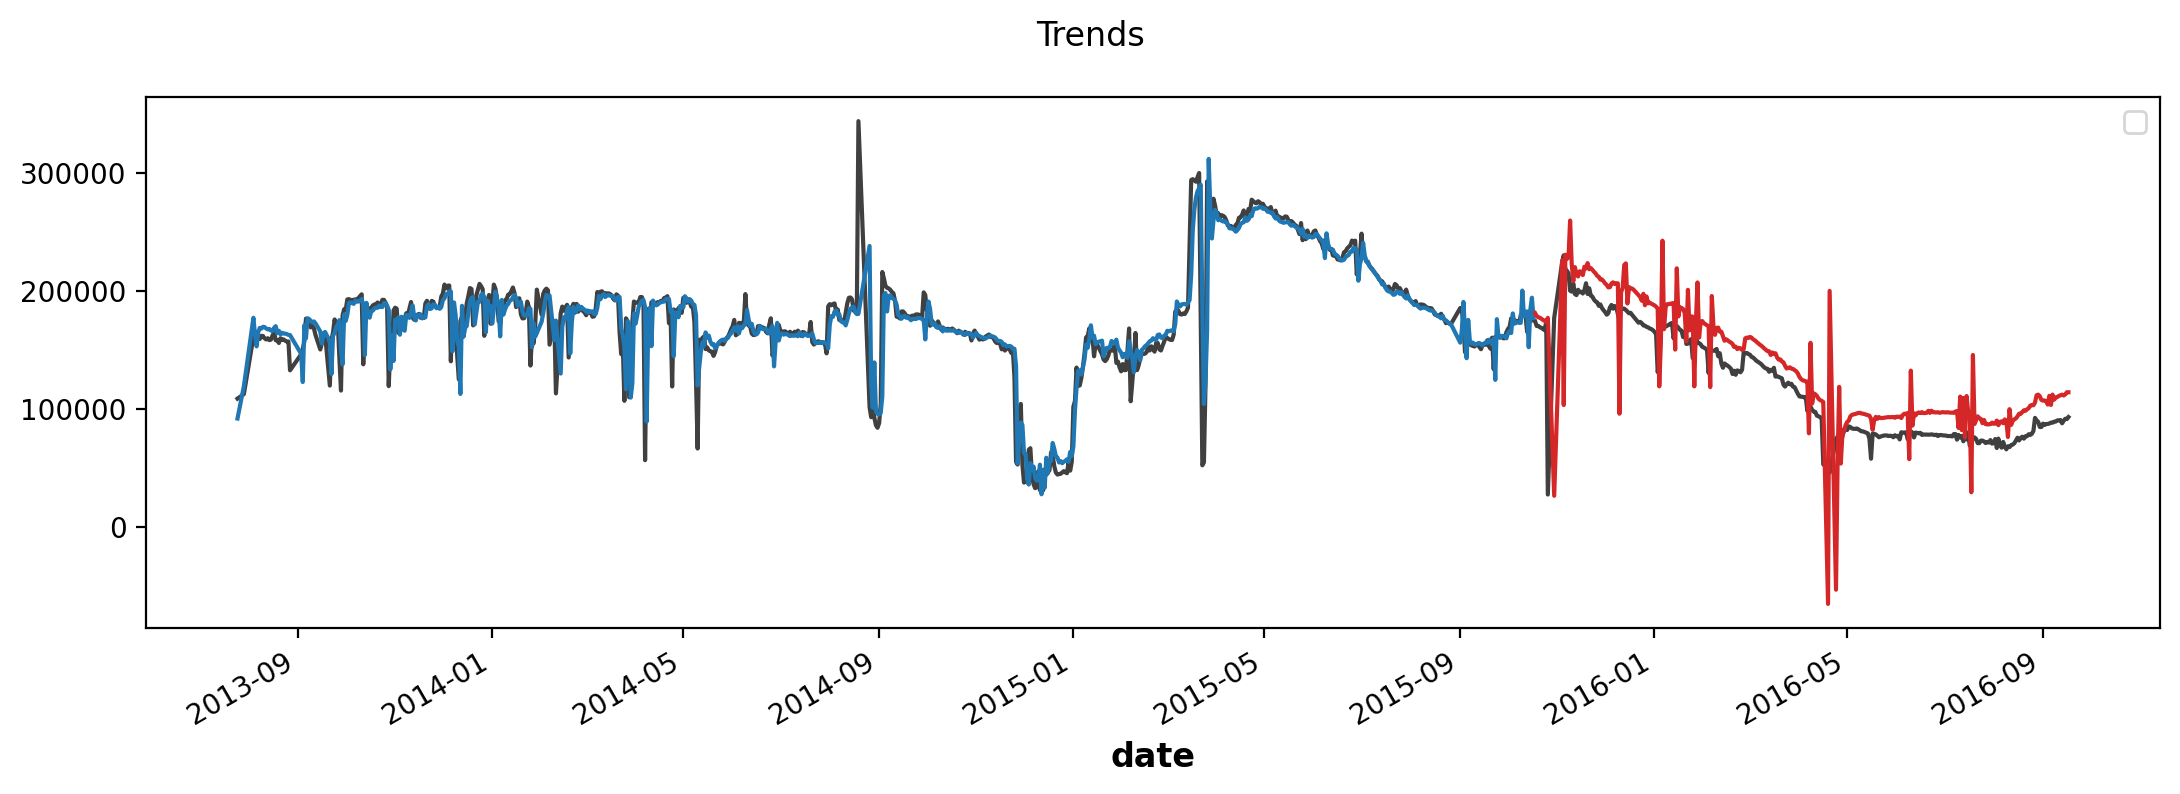

In [232]:
y = df["QG"]

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X3 = dp.in_sample()  # features for the training data
search_terms = ["bhp", "bht", "dp_tubing", "AVG_CHOKE_SIZE_P", "Time"]

# Create three lags for each search term
X0 = make_lags(df[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Create four lags for the target, as before
X1 = make_lags(df['QG'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1, X3], axis=1).fillna(0.0)

# Test on the years 2015/10-2016/9. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 27, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=["QG"],
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=["QG"],
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [233]:
y_pred

QG
date                     
2015-10-18  181453.320499
2015-10-19  179005.296478
2015-10-20  177927.266633
2015-10-21  177477.581598
2015-10-22  176618.268437
...                   ...
2016-09-13  112334.919407
2016-09-14  111608.245621
2016-09-15  112556.728622
2016-09-16  114371.399196
2016-09-17  114341.246348

[324 rows x 1 columns]

In [234]:
# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [235]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
# y_fit = y_fit.stack().squeeze()    # trend from training set
# y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit["QG"]

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit["QG"]
y_pred_boosted = xgb.predict(X_test) + y_pred["QG"]

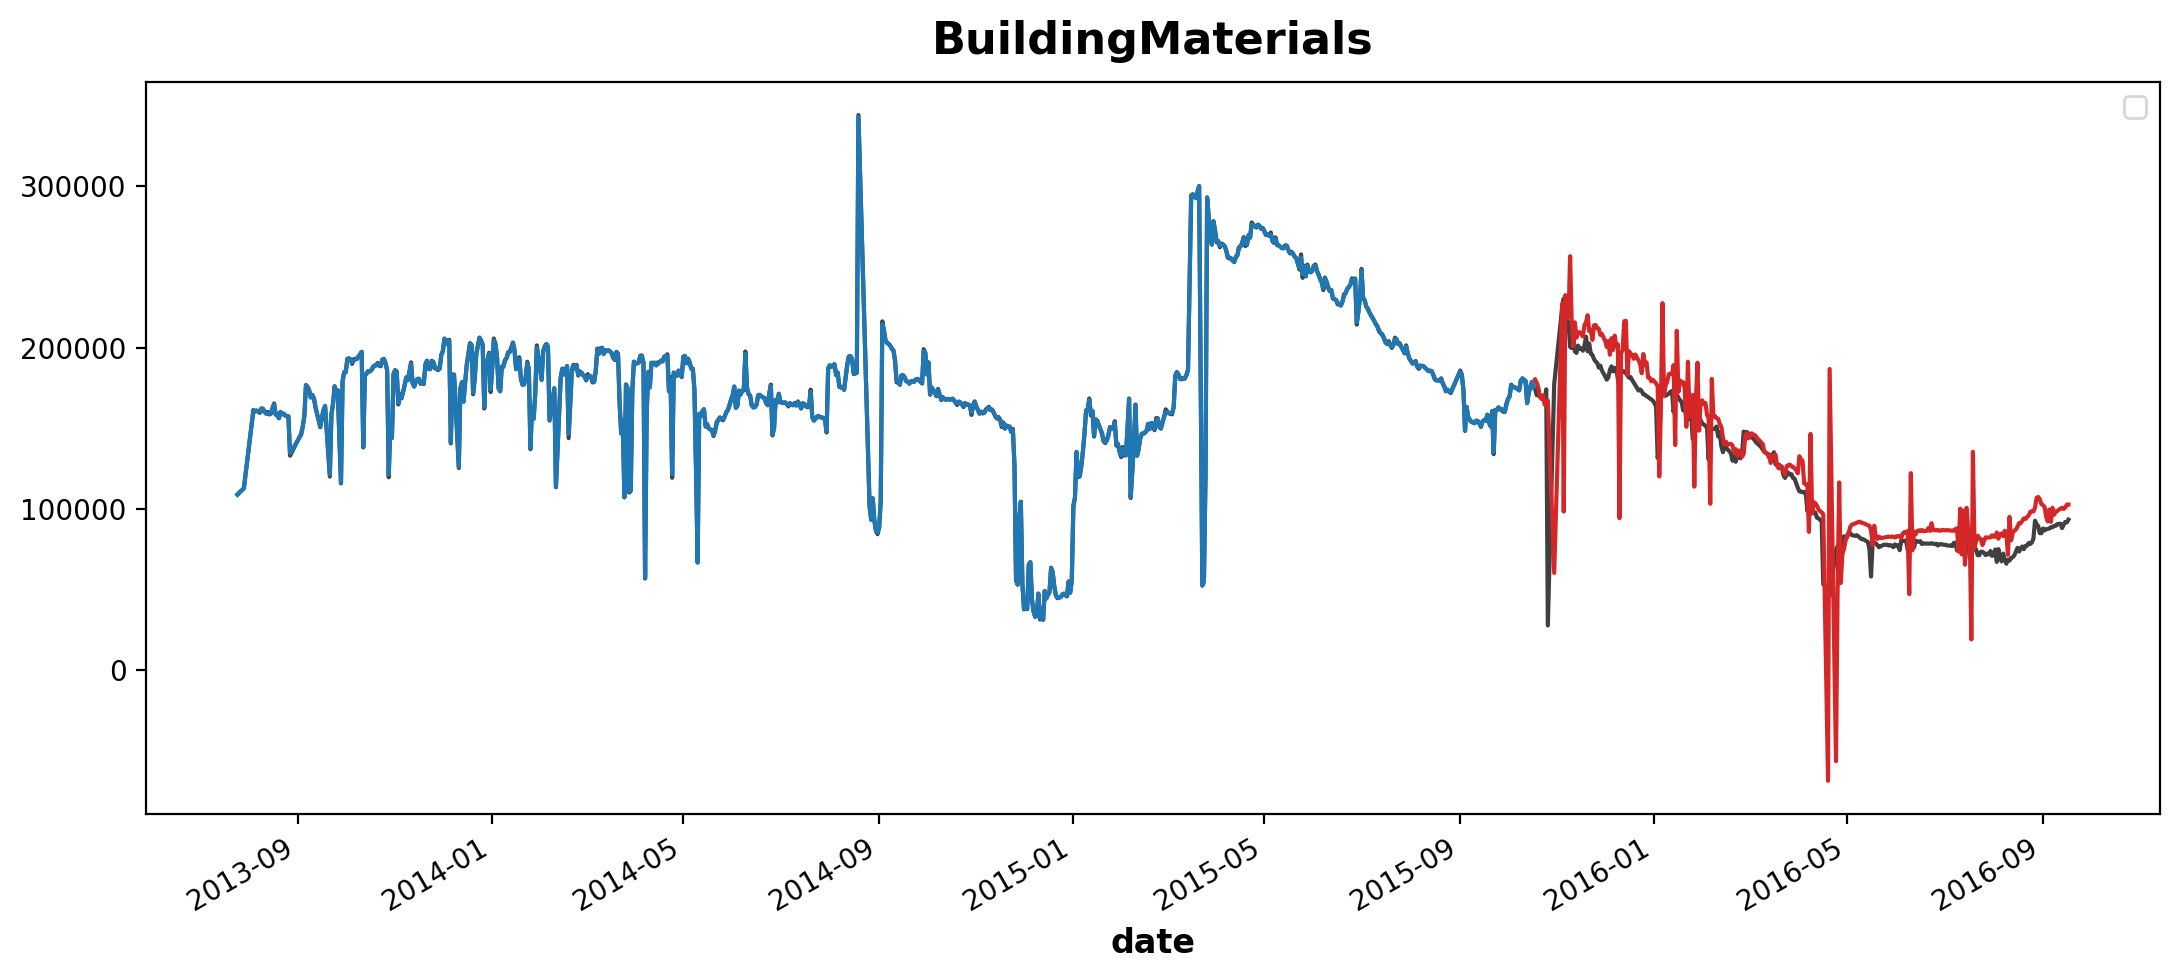

In [236]:
axs = y_train.plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials'],
)
axs = y_test.plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

<h1>Forecasting With Machine Learning</h1>

In [242]:
N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})
data = pd.concat({'Targets': y, 'Features': X}, axis=1)
data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

<h1>Exampel Of the context</h1>

In [35]:
# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

<h1>Multioutput model</h1>

In [36]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
    
# Four weeks of lag features
y = df.QG.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X3 = dp.in_sample()  # features for the training data
search_terms = ["bhp", "bht", "dp_tubing", "AVG_CHOKE_SIZE_P", "Time"]

# Create three lags for each search term
X0 = make_lags(df[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Create four lags for the target, as before
X1 = make_lags(df['QG'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1, X3], axis=1).fillna(0.0)



def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=10).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [38]:
X

y_lag_1 bhp  y_lag_1 bht  y_lag_1 dp_tubing  \
date                                                      
2013-07-25     0.000000     0.000000           0.000000   
2013-07-29   163.594260    60.315740          61.473080   
2013-08-04     0.000000     0.000000           0.000000   
2013-08-05   273.594368   105.439765         177.392876   
2013-08-06   272.298494   105.537800         176.786078   
...                 ...          ...                ...   
2016-09-04   253.743359   105.202066         227.090489   
2016-09-05   253.754032   105.210624         227.106882   
2016-09-06   253.800321   105.217583         227.069778   
2016-09-07   253.782709   105.223737         226.984874   
2016-09-08   253.761157   105.229843         227.018305   

            y_lag_1 AVG_CHOKE_SIZE_P  y_lag_1 Time  y_lag_2 bhp  y_lag_2 bht  \
date                                                                           
2013-07-25                  0.000000           0.0     0.000000     0.000000   
2013-07-29                  8.549131           1.0     0.000000     0.000000   
2013-08-04                  2.536987           5.0   163.594260    60.315740   
2013-08-05                  9.951288          11.0     0.000000     0.000000   
2013-08-06                  9.758748          12.0   273.594368   105.439765   
...                              ...           ...          ...          ...   
2016-09-04                 97.916667        1137.0   253.657242   105.195529   
2016-09-05                100.000000        1138.0   253.743359   105.202066   
2016-09-06                 97.916667        1139.0   253.754032   105.210624   
2016-09-07                100.000000        1140.0   253.800321   105.217583   
2016-09-08                100.000000        1141.0   253.782709   105.223737   

            y_lag_2 dp_tubing  y_lag_2 AVG_CHOKE_SIZE_P  y_lag_2 Time  ...  \
date                                                                   ...   
2013-07-25           0.000000                  0.000000           0.0  ...   
2013-07-29           0.000000                  0.000000           0.0  ...   
2013-08-04          61.473080                  8.549131           1.0  ...   
2013-08-05           0.000000                  2.536987           5.0  ...   
2013-08-06         177.392876                  9.951288          11.0  ...   
...                       ...                       ...           ...  ...   
2016-09-04         227.040281                100.000000        1136.0  ...   
2016-09-05         227.090489                 97.916667        1137.0  ...   
2016-09-06         227.106882                100.000000        1138.0  ...   
2016-09-07         227.069778                 97.916667        1139.0  ...   
2016-09-08         226.984874                100.000000        1140.0  ...   

            y_lag_3 dp_tubing  y_lag_3 AVG_CHOKE_SIZE_P  y_lag_3 Time  \
date                                                                    
2013-07-25           0.000000                  0.000000           0.0   
2013-07-29           0.000000                  0.000000           0.0   
2013-08-04           0.000000                  0.000000           0.0   
2013-08-05          61.473080                  8.549131           1.0   
2013-08-06           0.000000                  2.536987           5.0   
...                       ...                       ...           ...   
2016-09-04         227.004165                100.000000        1135.0   
2016-09-05         227.040281                100.000000        1136.0   
2016-09-06         227.090489                 97.916667        1137.0   
2016-09-07         227.106882                100.000000        1138.0   
2016-09-08         227.069778                 97.916667        1139.0   

              y_lag_1    y_lag_2    y_lag_3    y_lag_4  const   trend  \
date                                                                    
2013-07-25       0.00       0.00       0.00       0.00    1.0     1.0   
2013-07-29  108940.

In [49]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 26163.69
Test RMSE: 115900.94


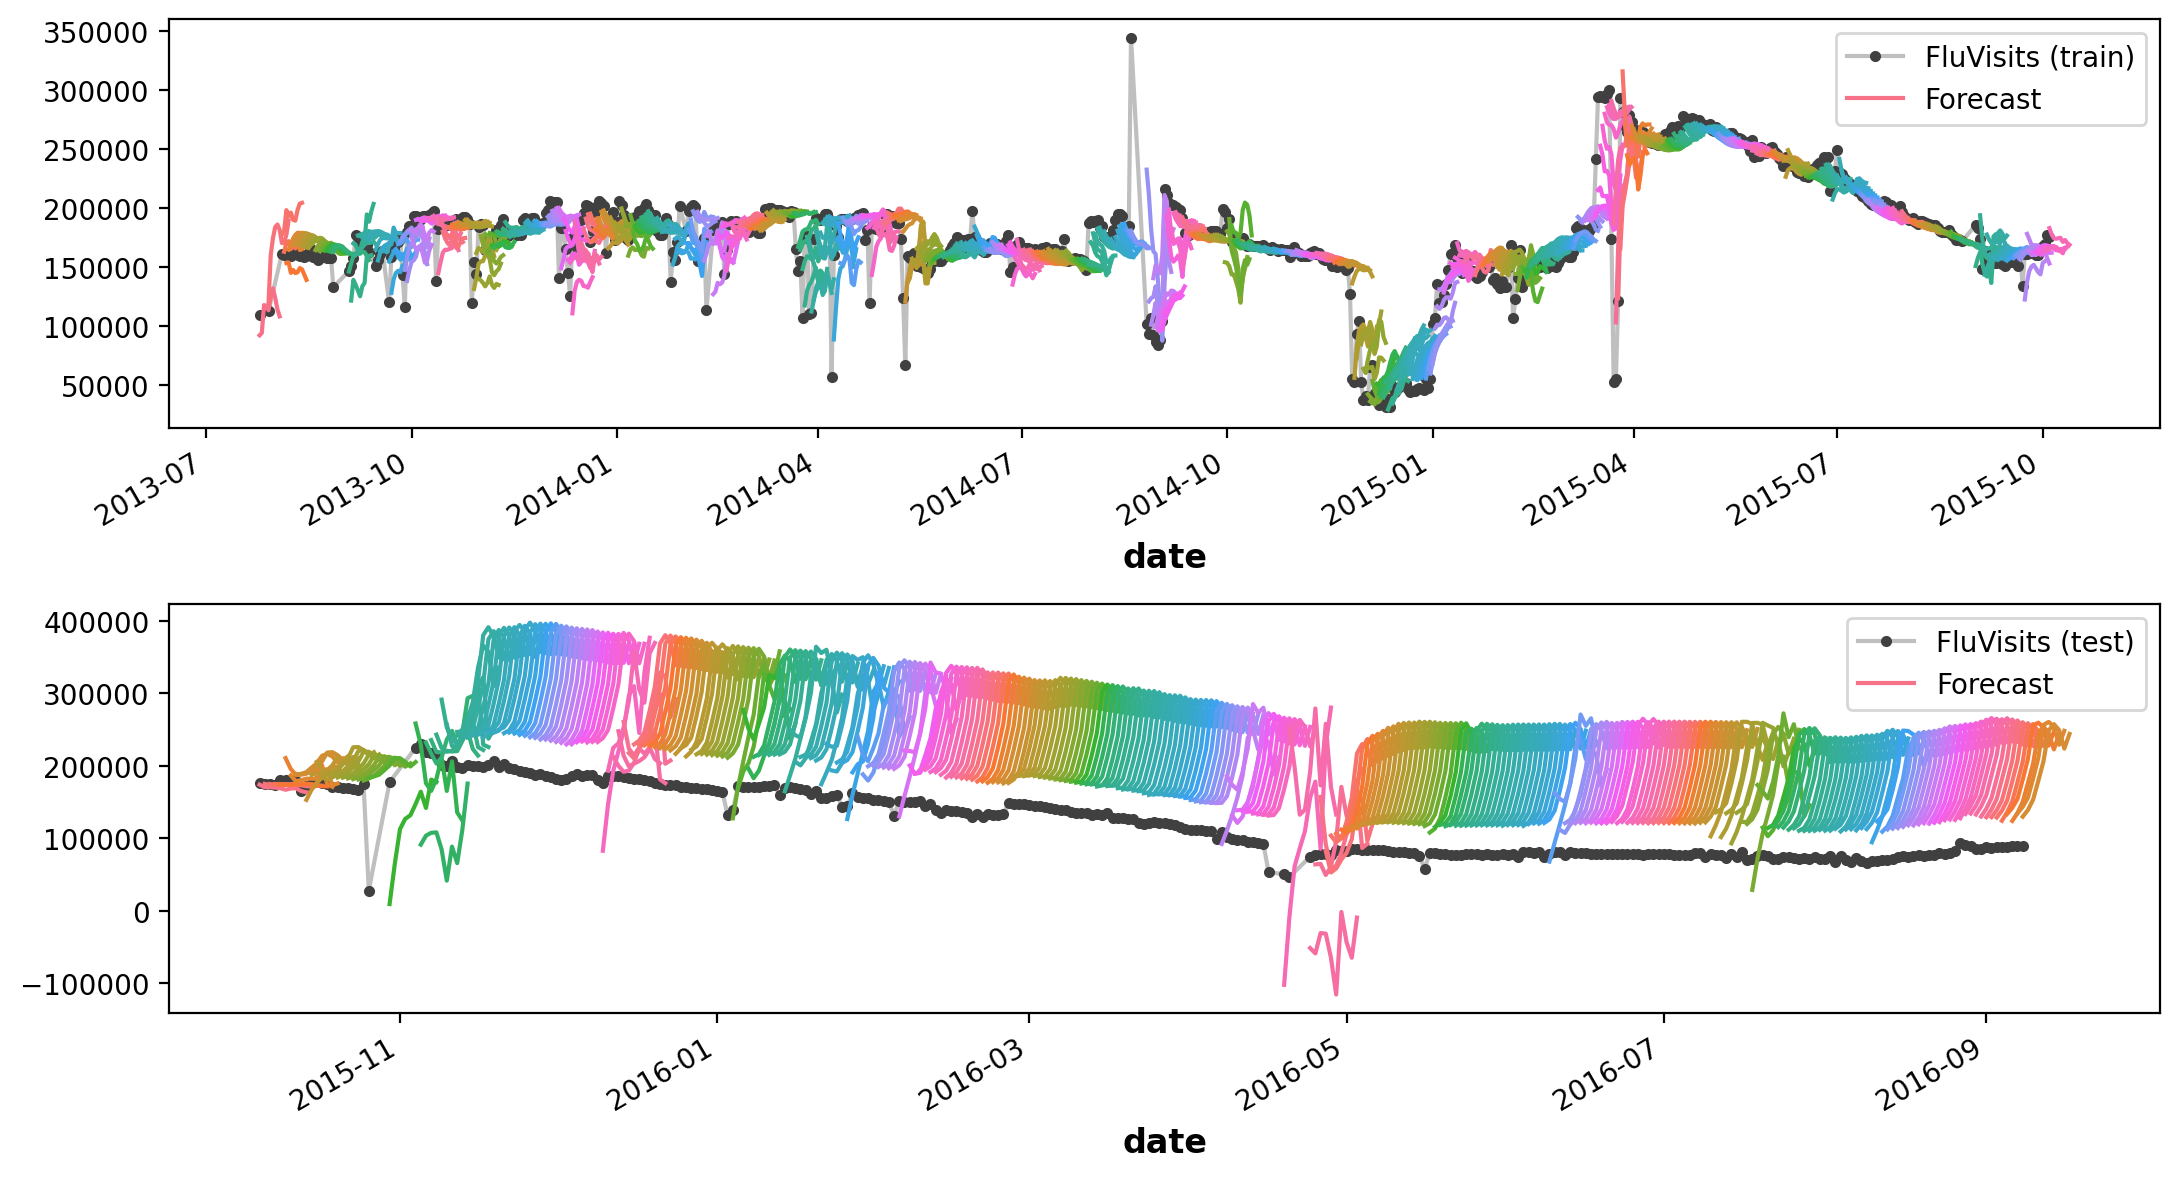

In [50]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = df.QG[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = df.QG[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

<h1>Direct strategy</h1>

In [51]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 506.03
Test RMSE: 43948.05


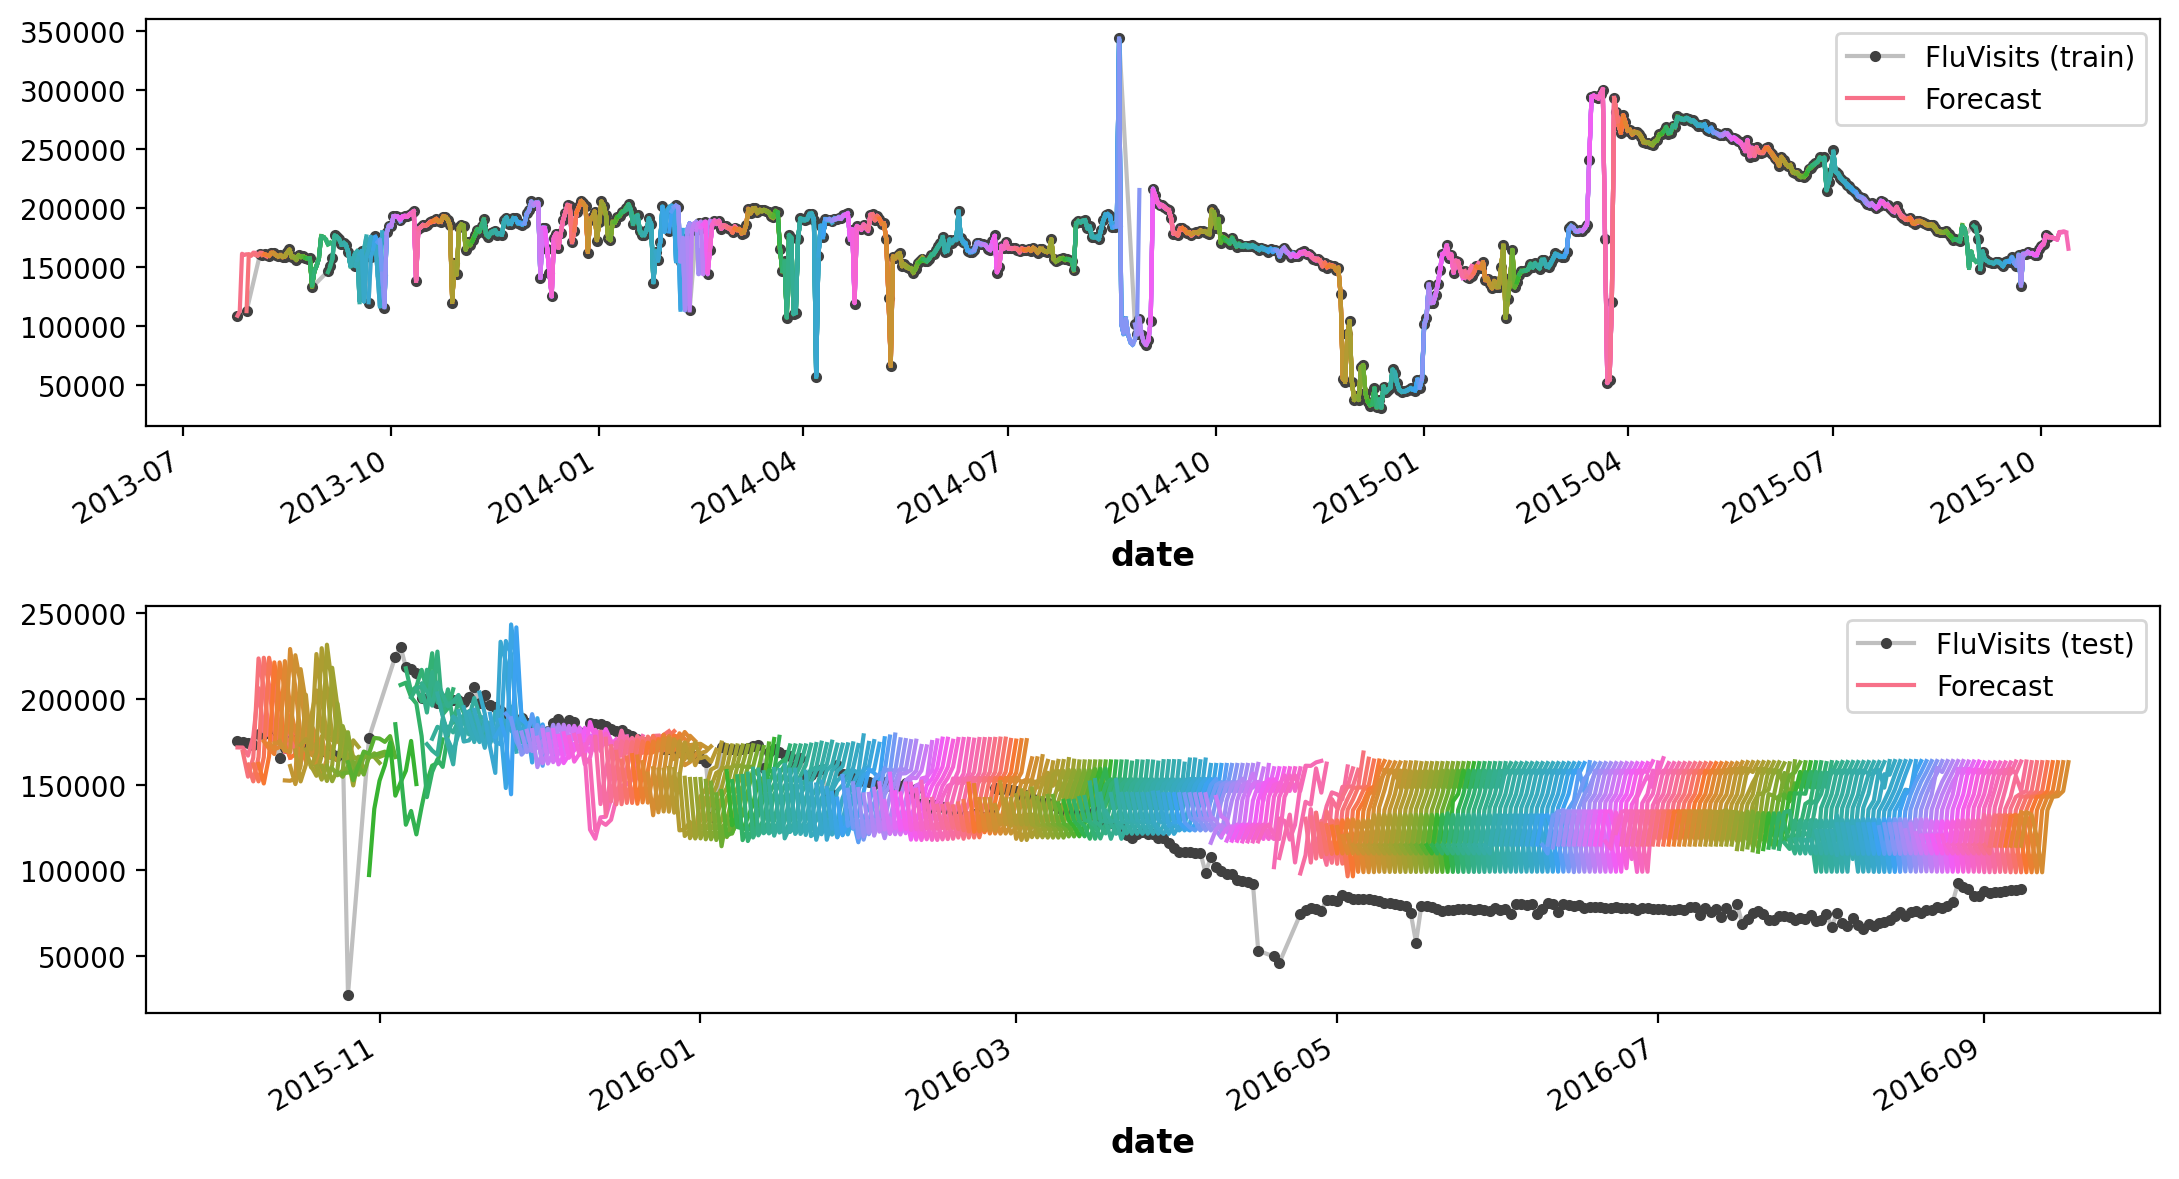

In [52]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = df.QG[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = df.QG[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

In [53]:
y_pred

y_step_1       y_step_2       y_step_3       y_step_4  \
date                                                                     
2015-10-05  171713.953125  171645.187500  166955.890625  178067.609375   
2015-10-06  169197.468750  154668.000000  165811.390625  223583.375000   
2015-10-07  161721.687500  151909.890625  166092.062500  223967.796875   
2015-10-08  161791.140625  151909.890625  166002.796875  223967.796875   
2015-10-09  162168.609375  150684.125000  166441.656250  221289.265625   
...                   ...            ...            ...            ...   
2016-09-04  114445.773438  131280.843750  132463.468750  118912.296875   
2016-09-05  114445.773438  131280.843750  132463.468750  118912.296875   
2016-09-06  114445.773438  131280.843750  132463.468750  118912.296875   
2016-09-07  114445.773438  134047.640625  132463.468750  119136.742188   
2016-09-08  114445.773438  134047.640625  132463.468750  119136.742188   

                 y_step_5       y_step_6       y_step_7      y_step_8  \
date                                                                    
2015-10-05  206240.625000  180976.906250  178699.281250  175499.28125   
2015-10-06  206627.062500  180388.328125  175966.140625  174223.84375   
2015-10-07  208103.421875  180729.546875  175265.703125  176245.34375   
2015-10-08  208103.421875  179315.312500  175371.468750  176245.34375   
2015-10-09  201288.937500  173375.687500  165702.343750  167685.81250   
...                   ...            ...            ...           ...   
2016-09-04   98943.429688  135159.421875  142857.703125  143347.37500   
2016-09-05   98943.429688  135159.421875  142857.703125  143347.37500   
2016-09-06   98943.429688  135159.421875  142857.703125  143347.37500   
2016-09-07   98943.429688  135159.421875  142857.703125  143347.37500   
2016-09-08   98943.429688  135159.421875  142857.703125  143347.37500   

                 y_step_9      y_step_10  
date                                      
2015-10-05  181847.203125  169194.671875  
2015-10-06  183352.218750  165652.421875  
2015-10-07  183293.828125  167331.156250  
2015-10-08  182969.250000  163433.000000  
2015-10-09  173328.937500  163433.000000  
...                   ...            ...  
2016-09-04  146250.234375  163121.015625  
2016-09-05  146250.234375  163121.015625  
2016-09-06  146250.234375  163121.015625  
2016-09-07  146250.234375  163121.015625  
2016-09-08  146250.234375  163121.015625  

[328 rows x 10 columns]